In [ ]:
!sudo apt update
!sudo apt-get update
!pip install --upgrade --force-reinstall pandas scipy numpy matplotlib
!pip install -U cartopy basemap
!pip uninstall -y shapely
!pip install shapely --no-binary shapely

!sudo apt-get install texlive-latex-recommended
!sudo apt install texlive-latex-base texlive-latex-extra texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

import os
os.kill(os.getpid(), 9)

# Imports

In [1]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy
import shapely as shp
from shapely import Point
import psutil
import time
import sys
import numpy as np
import networkx as nx
import pandas as pd
import scipy as sp
import scipy.fftpack as fftpack
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import re
from datetime import datetime
from tqdm.notebook import tqdm, trange
import gzip
import os
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches
from mpl_toolkits.basemap import Basemap
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset
from matplotlib import rc
%matplotlib inline

np.set_printoptions(linewidth=250)

font_dir = '/usr/local/lib/python' + str(sys.version_info[0]) + '.' + str(sys.version_info[1]) + '/dist-packages/matplotlib/mpl-data/fonts/ttf/'

# Mount Drive

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

# Set this as the directory in which to save figures
base_dir = '/content/gdrive/My Drive/Amazon Project/'
if not os.path.isdir(base_dir + 'Figures/'):
  os.mkdir(base_dir + 'Figures/')
fig_dir = base_dir + 'Figures/Graph Generation/'
if not os.path.isdir(fig_dir):
  os.mkdir(fig_dir)

data_dir = base_dir + 'Data/'
if not os.path.isdir(data_dir):
  os.mkdir(data_dir)

os.chdir(base_dir)

Mounted at /content/gdrive


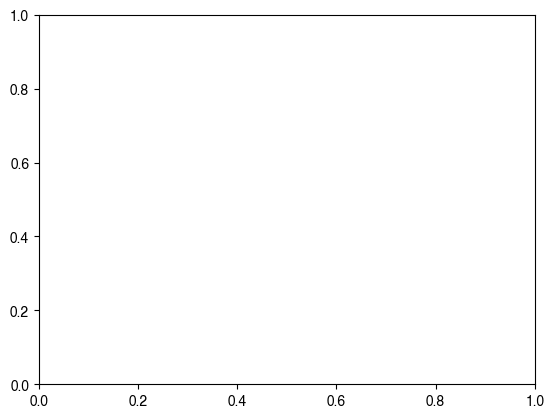

In [3]:
!cp Helvetica.ttf $font_dir

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']
plt.xticks(fontname = 'Helvetica')
plt.yticks(fontname = 'Helvetica')
rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{xfrac}')


plt.rcParams['savefig.bbox'] = 'tight'

import matplotlib.font_manager as fm
# fm.FontProperties(fname='/content/gdrive/MyDrive/Helvetica.ttf', size= 24)
fm.fontManager.addfont(font_dir + 'Helvetica.ttf')
# fm.fontManager.addfont(font_dir + 'helvetica.ttf')
# fm.fontManager.ttflist += fm.createFontList(['/content/gdrive/MyDrive/Helvetica.ttf'])
# mpl.rc('font', family='Helvetica')
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

prop = fm.FontProperties(fname=font_dir+'Helvetica.ttf')
# prop = fm.FontProperties(fname=font_dir+'helvetica.ttf')
font = {'fontname':'Helvetica'}

# Helper Functions

In [4]:
def haversine(lon1, lat1, lon2, lat2, r=6371):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
#     lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    lon1, lat1, lon2, lat2 = np.radians([lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return c * r

def haversine_np(lon1, lat1, lon2, lat2, r=6371):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    return c * r

def nearest_neighbors(lat,lon,latlon_icos, r=6371, num_neighbors=4, radius=None):
    """
    Find nearest neighbors (using geodesic distance) of given point

    if radius is None, find closest num_neighbors neighbors
    else, find list of neighbors within radius
    """
    lats = np.zeros((len(latlon_icos),)) + lat
    lons = np.zeros((len(latlon_icos),)) + lon
    distances = haversine_np(lons,lats,latlon_icos[:,1],latlon_icos[:,0], r)

    if radius is not None:
        neighbors = []
        for i in range(len(latlon_icos)):
            lat_icos, lon_icos = latlon_icos[i]
            if distances[i] <= radius:
                neighbors.append((i,distances[i]))
        return neighbors
    else:
        neighbors = [(i,distances[i]) for i in range(len(distances))]

        neighbors.sort(key = lambda k: k[1])
        return neighbors[:num_neighbors]

def interpolate_point(lat,lon,latlon_icos,data, r=6371, num_neighbors=4, radius=None):
    """
    Interpolate point using convolution of nearest geodesic neighbors - found either via
    fixed 'num_neighbors' scheme or via all points within 'radius' geodesic distance of input
    """
    neighbors = nearest_neighbors(lat,lon,latlon_icos, r=r,
                                  num_neighbors=num_neighbors, radius=radius)
    return np.sum([(1/dist)*data[i] for (i,dist) in neighbors])/np.sum([(1/dist) for (i,dist) in neighbors])

def interpolate_points(lats,lons,latlon_icos,data, r=6371, num_neighbors=4, radius=None, desc=''):
    """
    Interpolate a sequence of latitude-longitude points given by 'lats' and 'lons' (equal size 1D array)
    using convolution of nearest geodesic neighbors - found either via
    fixed 'num_neighbors' scheme or via all points within 'radius' geodesic distance of input
    """
    results = np.zeros((len(lats),))
    for i in trange(len(lats), desc=desc, leave=False):
        lat, lon = lats[i], lons[i]
        results[i] = interpolate_point(lat,lon,latlon_icos,data, r=r,
                                       num_neighbors=num_neighbors,
                                       radius=radius)
    return results

def replace_points_near_poles(ilat, ilon, idat, latlon_icos, data,
                              threshold=15, num_neighbors=4, radius=None):
    """
    To fix artifacting near poles, manually interpolate with nearest neighbors

    ilon, ilat is meshgrid over globe
    idat is associated interpolation of data
    data is list of some value for each node in latlon_icos

    90-threshold and -90+threshold (in degrees) are latidues to replace

    """
    close_to_poles = np.concatenate((np.where(abs(ilat[:,0]-90) < threshold)[0],
                                     np.where(abs(ilat[:,0]+90) < threshold)[0]))

    lons = [lon for i in range(len(close_to_poles)) for lon in ilon[0,:]]
    lats = [ilat[lat,0] for lat in close_to_poles for i in range(len(ilon[0,:]))]

    results_close_to_poles = interpolate_points(lats,lons,latlon_icos,data,
                                                num_neighbors=num_neighbors,
                                                radius=radius,
                                                desc = 'Replacing Poles')

    nj = len(ilon[0,:])
    for i in range(len(close_to_poles)):
        lat_ind = close_to_poles[i]
        for j in range(nj):
            idat[lat_ind,j] = results_close_to_poles[nj*i + j]

    return idat

def replace_points_near_dateline(ilat, ilon, idat, latlon_icos, data,
                                 threshold=5, num_neighbors=4, radius=None):
    """
    To fix artifacting near dateline, manually interpolate with longitude periodicity from 0 to 360

    ilon, ilat is meshgrid over globe
    idat is associated interpolation of data
    data is list of some value for each node in latlon_icos

    +/- threshold (in degrees) are longitudes to replace

    """
    close_to_dateline = np.concatenate((np.where(abs(ilon[0,:]) < threshold)[0],
                                        np.where(abs(ilon[0,:]-360) < threshold)[0]))

    lons = [ilon[0,lon] for lon in close_to_dateline for i in range(len(ilat[:,0]))]
    lats = [lat for i in range(len(close_to_dateline)) for lat in ilat[:,0]]

    results_close_to_dateline = interpolate_points(lats,lons,latlon_icos,data,
                                                   num_neighbors=num_neighbors,
                                                   radius=radius,
                                                   desc = 'Replacing Dateline')

    nj = len(ilat[:,0])
    for i in range(len(close_to_dateline)):
        lon_ind = close_to_dateline[i]
        for j in range(nj):
            idat[j,lon_ind] = results_close_to_dateline[nj*i + j]

    return idat

def replace_points_where_nan(ilat, ilon, idat, latlon_icos, data, num_neighbors=4, radius=None):
    """
    Use custom interpolation (using nearest geodesic neighbors) for points that are np.nan

    Can be used to simply fill in values mixed in scipy griddata interpolation due to longitude
    or latitude outside input icosahedral range.

    However, it is not guaranteed that this will fix the seam at the dateline - values with longtidue
    slightly larger than 0 may not smoothly vary since usually the scipy griddata interpolation misses
    data just to the *WEST* of the dateline. Therefore even if those missing values are replaced, there
    may be a seam across the dateline (longutude 0 degrees). TO FIX THIS, SIMPLY USE THE
    replace_points_near_dateline FUNCTION TO INTERPOLATE DATA TO THE WEST *AND* EAST OF THE DATELINE.
    """
    where = np.where(np.isnan(idat))

    lats = ilat[where[0],0]
    lons = ilon[0,where[1]]

    results_where_nans = interpolate_points(lats,lons,latlon_icos,data,
                                            num_neighbors=num_neighbors,
                                            radius=radius,
                                            desc = 'Replacing NaNs')

    for i in range(len(lats)):
        lat_ind = where[0][i]
        lon_ind = where[1][i]

        idat[lat_ind,lon_ind] = results_where_nans[i]

    return idat

def replace_points_in_shapefile(shape_filename, ilat, ilon, idat, fill_value=np.nan, inside=True):
    """
    This function can read a shapefile and fill values from the interpolated grid with 'fill_value'
    when they fall inside of the shapefile. This is useful since the interpolation of scatter data will
    fill in all values - even those that are intentionally left blank.

    OPTIONALLY: Specify inside=False to reverse which points are excluded - here the points *OUTSIDE*
    the shapefile are filled with 'fill_value'.

    TODO: Check if shapefiles with multiple polygons will break function - it was only tested with a
    contiguous-polygon shapefile.
    """
    from shapely.ops import unary_union
    import shapely.vectorized

    reader = shpreader.Reader(shape_filename)

    shape_geom = unary_union(list(reader.geometries()))

    shape_mask = shapely.vectorized.contains(shape_geom, ilon, ilat)
    shape_mask = np.logical_or(shape_mask,
                   shapely.vectorized.contains(shape_geom, ilon-360, ilat))

    idat[np.where(shape_mask == inside)] = fill_value

    return idat

def interpolate_scatter_data(latlon_icos, data, method='linear',
                             threshold_dateline=5, threshold_poles=15,
                             replace_nans = True,
                             num_neighbors=4, radius=None,
                             extent=[0, 360, -90, 90], filler=0,
                             num_interp_pts=200, shape_filename=None,
                             fill_value=np.nan):
    """
    This function takes scatter data as input - with (presumably icosahedral) coordinates 'latlon_icos',
    which is an (N,2)-size list of latitude-longitude pairs, and length-N 'data' specifying the pertinent
    qualitative information for each latitude-longitude pair.

    The output of the function is interpolated grid data intended for use in a contourf plot, consiting of
    'ilon' longitudinal grid - (num_interp_pts,num_interp_pts)
    'ilat' latitudinal grid - (num_interp_pts,num_interp_pts)
    'idat' grid data - (num_interp_pts,num_interp_pts)

    The basic interpolation is performed with scipy.interpolate.griddata, which currently has the flaw of
    not extrapolating under a method='linear' interpolation scheme. It also currently has no way to make
    use of the periodicity over the dateline (longitude = 0 degrees).

    In order to fix the missing points left by scipy.interpolate.griddata, three methods were developed:
    1) Replace points within some degree longitude of the dateline
    2) Replace points within some degree of the poles
    3) Replace all points filled with np.nan
    All three methods utilize a nearest-neighbor convolution, where points with low geodesic distance to
    the grid point are put under a weighted average to fill the grid data. See the function
    interpolate_points for details.

    Lastly, optionally fill values that fall inside (or outside) a supplied shapefile with given 'fill_value'.
    """
    from scipy.interpolate import griddata

    ilon = np.linspace(extent[0]-filler, extent[1]+filler, num_interp_pts)
    ilat = np.linspace(extent[2]-filler, extent[3]+filler, num_interp_pts)
    ilon, ilat = np.meshgrid(ilon, ilat)
    idat = griddata((latlon_icos[:,1], latlon_icos[:,0]), data,
                    (ilon, ilat), method=method)

    if threshold_dateline > 0:
        idat = replace_points_near_dateline(ilat, ilon, idat, latlon_icos,
                                            data, threshold=threshold_dateline,
                                            num_neighbors=num_neighbors,
                                            radius=radius)
    if threshold_poles > 0:
        idat = replace_points_near_poles(ilat, ilon, idat, latlon_icos,
                                         data, threshold=threshold_poles,
                                         num_neighbors=num_neighbors,
                                         radius=radius)
    if replace_nans:
        idat = replace_points_where_nan(ilat, ilon, idat, latlon_icos, data,
                                        num_neighbors=num_neighbors,
                                        radius=radius)

    if shape_filename is not None:
        idat = replace_points_in_shapefile(shape_filename, ilat, ilon,
                                           idat, fill_value=fill_value)

    return ilat, ilon, idat

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False),
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = mpl.colors.LinearSegmentedColormap(name, cdict)
    try:
        # mpl.cm.unregister_cmap(name)
        mpl.colormaps.unregister(name)
    except:
        pass
    # plt.register_cmap(cmap=newcmap)
    mpl.colormaps.register(cmap=newcmap)

    return newcmap

def yy_to_yyyy(yy):
    """
    Convert string of year in yy format to string in yyyy format
    """
    yy_int = int(yy)
    if yy_int < 10:
        return '200' + str(yy_int)
    elif yy_int < 48:
        return '20' + str(yy_int)
    else:
        return '19' + str(yy_int)


def start_year_to_date_range(start_year,year_interval=25):
    """
    Convert string of start year in yy format to date range string in yyyy-yyyy format
    """
    start = yy_to_yyyy(start_year)
    end = str(int(start) + year_interval)
    return start + '-' + end

def match_nodes(dates,finallons_dict,finallats_dict):
    f = gzip.open(data_dir + '/G/'+dates[0]+'.data','rb')
    G = pkl.load(f)
    f.close()
    N = G.number_of_nodes()

    node_matches = np.zeros((N,len(dates)))
    for node in G.nodes():
        node_matches[node,0] = node

    for i in trange(1,len(dates),desc='Matching'):
        for j in range(N):
            node_matches[j,i] = np.where(np.logical_and(finallons_dict[dates[i]] == finallons_dict[dates[0]][j],
                                   finallats_dict[dates[i]] == finallats_dict[dates[0]][j]))[0][0]

    return node_matches.astype(int)

def get_trend(trend_dict,dates,finallons_dict,finallats_dict,normalize=False):
    f = gzip.open(data_dir + '/G/'+dates[0]+'.data','rb')
    G = pkl.load(f)
    f.close()
    nodes = list(G.nodes())

    node_matches = match_nodes(dates,finallons_dict,finallats_dict)

    trend = np.zeros((len(nodes),1))

    for node in nodes:
#         slope, _ = np.polyfit(list(range(48)), [trend_dict[date][node,1] for date in dates], 1)
        slope, _ = np.polyfit(list(range(48)), [trend_dict[dates[i]][node_matches[node,i]] for i in range(len(dates))], 1)
        trend[node] = slope

    if normalize:
#         return np.interp(trend, (trend.min(), trend.max()), (-1, +1))
        return trend/abs(min(trend))
    else:
        return trend

# Plots

In [5]:
with gzip.open(data_dir + 'lats.data', 'rb') as file:
    lats = pkl.load(file)

with gzip.open(data_dir + 'lons.data', 'rb') as file:
    lons = pkl.load(file)

latlon_raw = np.array([(lat,lon) for lat in lats for lon in lons])
print(latlon_raw.shape)

(10512, 2)


In [6]:
def get_adjacent_points(point_list,n_iter):
  adj_points = []
  for i in range(len(point_list)):
    v1 = point_list[i]
    for j in range(i,len(point_list)):
      v2 = point_list[j]
      x1,y1,z1 = v1[0],v1[1],v1[2]  ## first points
      x2,y2,z2 = v2[0],v2[1],v2[2]  ## second point

      d = np.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)
      if 2/(2**n_iter)-0.05<=d and d<=2/(2**n_iter)+0.05:
        adj_points.append([v1,v2])
  return adj_points

def get_midpoint(orig_list,adj_point_list):
  final_list = list(orig_list)
  for i in range(len(adj_point_list)):
    v1 = adj_point_list[i][0]
    v2 = adj_point_list[i][1]
    x1,y1,z1 = v1[0],v1[1],v1[2]   ## first point
    x2,y2,z2 = v2[0],v2[1],v2[2]   ## second point
    mid_x,mid_y, mid_z = (x1+x2)/2,(y1+y2)/2,(z1+z2)/2   ## midpoints of two points
    midpoint = (mid_x,mid_y,mid_z)
    final_list.append(midpoint)     ## It will append the midpoints to the other 12 grid points
  return final_list

def triangulate_icosahedron(icosahedron,n_iterations):
  for i in range(n_iterations):
    adj = get_adjacent_points(icosahedron,i)
    icosahedron = get_midpoint(icosahedron,adj)
  return icosahedron

def project(final,radius):
  sphere_triangulation = []
  for point in final:
    x,y,z = point[0],point[1],point[2]
    mag = np.sqrt(x**2+y**2+z**2)              ## magnitude of a point
    sphere_point = (radius*x/mag,radius*y/mag,radius*z/mag)      ## projection of that point into sphere
    sphere_triangulation.append(sphere_point)
  return sphere_triangulation

def convert(points,r):
  latlonlist = []
  for pnt in points:
    x,y,z = pnt[0],pnt[1],pnt[2]
    x,y,z = round(x,6),round(y,6),round(z,6)   ## round to 6 decimal digits
    lat,lon = 0,0
    if x == 0:
      if y >= 0:
        lon = 90.0
      else:
        lon = 270.0
    else:
      lon = np.degrees(np.arctan2(y,x))      ## lon from (0 to 360) as usual cartesian coordinate
      if lon < 0:
        lon = 360+lon
    lat = 90-np.degrees(np.arccos(z/r))        ## if z>0 then lat is positive otherwise negative
    latlonlist.append((lat,lon))
  return latlonlist

def findgridpoints(icospoint,lats,lons):
  '''
  Finds the four grid points that surround
  each point on the icosahedral grid
  '''
  icoslat, icoslon = icospoint

  done=False
  i=0
  gridlat1,gridlon1=0,0
  gridlat2,gridlon2=0,0
  #Iterate through the latitudes and longitudes of the regular latitude-longitude
  #grid, when the latitude/longitude of the icosahedral grid point is in between
  #two of the values in the regular grid, store them
  #
  #The latitude iterations will always find the surrounding latitudes, the
  #longitude iterations will halt at 357.5 degrees, and store the longitudes
  #357.5 degrees and 0 degrees.
  while not done:
    if lats[i]>=icoslat and lats[i+1]<=icoslat:
      done=True
      gridlat1=lats[i]
      gridlat2=lats[i+1]
    else:
      i+=1
  i1 = i
  i2 = i+1

  done=False
  j=0
  while not done:
    if lons[j]<=icoslon and lons[j+1]>=icoslon:
      done=True
      gridlon1=lons[j]
      gridlon2=lons[j+1]
    else:
      j += 1
      if j == len(lons)-1:
        done=True
        gridlon1=lons[-1]
        gridlon2=360
  if j == 143:
    j1 = -1
    j2 = 0
  else:
    j1 = j
    j2 = j+1

  # lats = np.array(lats) - icoslat
  # for i in range(len(lats)):
  #   if lats[i] <= 0:
  #     gridlat1, gridlat2 = lats[i-1]+icoslat, lats[i]+icoslat
  #     break
  # i1 = i-1
  # i2 = i

  # if icoslon >= lons[-1]:
  #   gridlon1, gridlon2 = lons[-1], 360
  #   j1 = -1
  #   j2 = 0
  # else:
  #   lons = np.array(lons) - icoslon
  #   for j in range(len(lons)):
  #     if lons[j] >= 0:
  #       gridlon1, gridlon2 = lons[j-1]+icoslon, lons[j]+icoslon
  #       break
  #   j1 = j-1
  #   j2 = j

  return gridlat1, gridlat2, gridlon1, gridlon2, i1, i2, j1, j2

def projectdata(icoslatslons,nctimeseries,lats,lons):
  icosahedral_data = np.zeros((len(icoslatslons),len(nctimeseries[0][0])))
  for i in trange(len(icoslatslons)):
    x, y = icoslatslons[i]
    x1, x2, y1, y2, x1id, x2id, y1id, y2id = findgridpoints((x,y),lats,lons)
    # T11 = nctimeseries[x1id][y1id]
    # T21 = nctimeseries[x2id][y1id]
    # T12 = nctimeseries[x1id][y2id]
    # T22 = nctimeseries[x2id][y2id]
    # pointTS = []
    for t in range(len(nctimeseries[x1id][y1id])):
      xy1 = (x2-x)/(-2.5)*nctimeseries[x1id][y1id][t] + (x-x1)/(-2.5)*nctimeseries[x2id][y1id][t]
      xy2 = (x2-x)/(-2.5)*nctimeseries[x1id][y2id][t] + (x-x1)/(-2.5)*nctimeseries[x2id][y2id][t]
      temp = (y2-y)*xy1/(2.5) + (y-y1)*xy2/(2.5)
      icosahedral_data[i,t] = temp
      # pointTS.append(temp)
    # icosahedral_data.append(pointTS)
  return icosahedral_data

def daily_anomalies(data):
  n=np.shape(data)[1] #number of nodes
  k=np.shape(data)[0]
  n1=n#np.shape(data)[1]-(365*14)
  for j in trange(k):
    for i in range(365):
      indices=np.arange(i,n,365)
      indices1=np.arange(i,n1,365)
      data[j,indices]=(data[j,indices]-np.mean(data[j,indices1]))/(np.std(data[j,indices1]))
  return data

In [7]:
pp = 5

p=(1+np.sqrt(5))/2                                       #golden ratio
icos=[(1,p,0),(-1,p,0),(1,-p,0),(-1,-p,0),
    (0,1,p),(0,-1,p),(0,1,-p),(0,-1,-p),
    (p,0,1),(p,0,-1),(-p,0,1),(-p,0,-1)]     # 12 icosahedron vertices
rad=np.sqrt(1+p**2)         #radius of sphere that circumscribes the icosahedron

latlon_icos = np.array(sorted(convert(project(triangulate_icosahedron(icos,pp),rad),rad),
                              key=lambda k:[k[1],k[0]]))
print(latlon_icos.shape)

(10242, 2)


In [57]:
with gzip.open(data_dir + 'surface_air_temperature.data', 'rb') as file:
    _ = pkl.load(file)
    _ = pkl.load(file)
    air = pkl.load(file)

anomalies_raw = daily_anomalies(air.reshape(air.shape[0]*air.shape[1],air.shape[2]))
print(anomalies_raw.shape)

  0%|          | 0/10512 [00:00<?, ?it/s]

(10512, 27549)


In [58]:
with gzip.open(data_dir + 'icosahedral_data.data', 'rb') as file:
    anomalies_icos = pkl.load(file)

# anomalies_icos = daily_anomalies(anomalies_icos)
print(anomalies_icos.shape)

(10242, 27549)


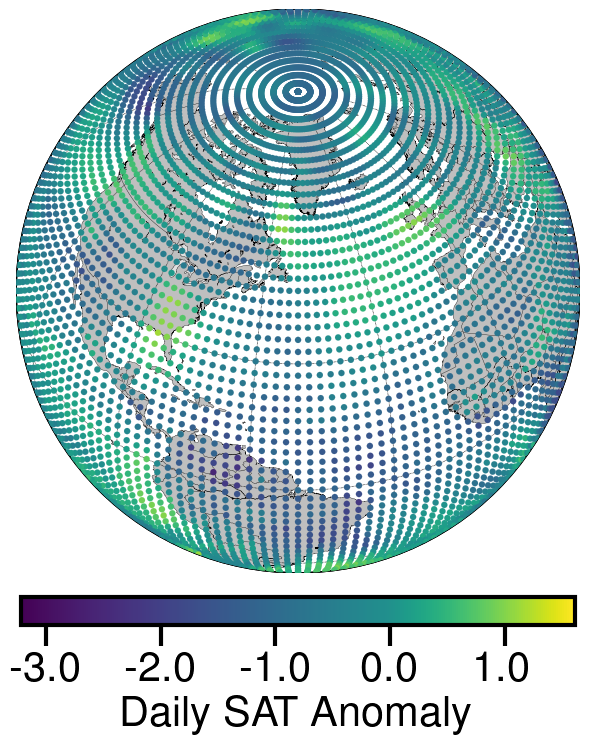

In [59]:
class MagnitudeFormatter(mpl.ticker.ScalarFormatter):
    def __init__(self, exponent=None):
        super().__init__()
        self._fixed_exponent = exponent

    def _set_order_of_magnitude(self):
        if self._fixed_exponent:
            self.orderOfMagnitude = self._fixed_exponent
        else:
            super()._set_order_of_magnitude()

fig, ax = plt.subplots(1,1,figsize=(8,8))

lw = 0.5
alpha = 0.5
fontsize = 30

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

bmap = Basemap(projection='ortho',lat_0=45,lon_0=-50,resolution='l', ax=ax)
# draw coastlines, country boundaries, fill continents.
bmap.drawcoastlines(linewidth=0.25)
bmap.drawcountries(linewidth=0.25)
bmap.fillcontinents(color='gray',lake_color=None,alpha=alpha)
# draw the edge of the map projection region (the projection limb)
bmap.drawmapboundary(fill_color=None,zorder=0)
# draw lat/lon grid lines every 30 degrees.
bmap.drawmeridians(np.arange(0,360,30),linewidth=lw)
bmap.drawparallels(np.arange(-90,90,30),linewidth=lw)


# im = bmap.scatter(latlon_raw[::,1], latlon_raw[::,0], s=10, c='k', latlon=True, zorder=5,
#                  marker='o', edgecolors=None, cmap='magma_r', alpha=1,
#                  vmin=min_degree, vmax=max_degree)#, transform=ccrs.PlateCarree())

i = 0
anomalies_min = min(anomalies_raw[:,i])
anomalies_max = max(anomalies_raw[:,i])
max_magnitude = max(abs(anomalies_min),anomalies_max)
midpoint = -anomalies_min/(anomalies_max-anomalies_min)
# midpoint = 0.5

cmap = mpl.cm.viridis
cmap = shiftedColorMap(cmap, midpoint=midpoint)

im = bmap.scatter(latlon_raw[::,1], latlon_raw[::,0], s=20, c=anomalies_raw[:,i],
                  latlon=True, zorder=5, marker='o', edgecolors=None, cmap=cmap, linewidths=0.1,
                  alpha=1, vmin=anomalies_min, vmax=anomalies_max)#, transform=ccrs.PlateCarree())


cbar=plt.colorbar(im, ax=ax, orientation='horizontal',fraction=0.045, pad=0.04)
cbar.set_label(r'Daily SAT Anomaly',fontsize=fontsize)

tick_locator = mpl.ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()

ticks = cbar.get_ticks()[1:-1]
multiplier = int('{:e}'.format(ticks[-1]).split('e')[1])
fmt = MagnitudeFormatter(multiplier)
cbar.ax.xaxis.set_major_formatter(fmt)
# plt.ticklabel_format(style='sci', axis='y')
# print(ax.yaxis.get_major_formatter().__dict__)
cbar.ax.xaxis.offsetText.set_visible(False)

# print(yticks)
cbar.set_ticks(ticks)
cbar.set_ticklabels(['{:.1f}'.format(tick/10**multiplier) for tick in ticks])

if multiplier != 0:
    cbar.ax.annotate(r'$\times 10^{'+str(multiplier)+r'}$', xy=(0.95,1.05), xycoords='axes fraction', ha='left', va='bottom', fontsize=fontsize)


plt.setp(ax.spines.values(), linewidth=2)
cbar.outline.set_linewidth(3)
cbar.ax.tick_params(length=15,width=3)



title = 'Raw Grid'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2)
plt.savefig(fig_dir+title+'.eps',bbox_inches='tight',pad_inches=0.2)
plt.show()
plt.close(fig)

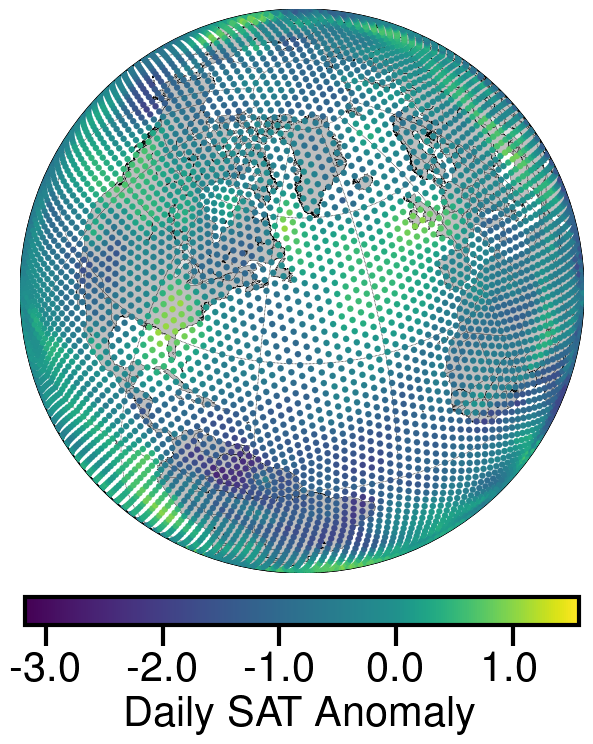

In [60]:
class MagnitudeFormatter(mpl.ticker.ScalarFormatter):
    def __init__(self, exponent=None):
        super().__init__()
        self._fixed_exponent = exponent

    def _set_order_of_magnitude(self):
        if self._fixed_exponent:
            self.orderOfMagnitude = self._fixed_exponent
        else:
            super()._set_order_of_magnitude()

fig, ax = plt.subplots(1,1,figsize=(8,8))

lw = 0.5
alpha = 0.5
fontsize = 30

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

bmap = Basemap(projection='ortho',lat_0=45,lon_0=-50,resolution='l', ax=ax)
# draw coastlines, country boundaries, fill continents.
bmap.drawcoastlines(linewidth=0.25)
bmap.drawcountries(linewidth=0.25)
bmap.fillcontinents(color='gray',lake_color=None,alpha=alpha)
# draw the edge of the map projection region (the projection limb)
bmap.drawmapboundary(fill_color=None,zorder=0)
# draw lat/lon grid lines every 30 degrees.
bmap.drawmeridians(np.arange(0,360,30),linewidth=lw)
bmap.drawparallels(np.arange(-90,90,30),linewidth=lw)


# im = bmap.scatter(latlon_icos[::,1], latlon_icos[::,0], s=10, c='k', latlon=True, zorder=5,
#                  marker='o', edgecolors=None, cmap='magma_r', alpha=1,
#                  vmin=min_degree, vmax=max_degree)#, transform=ccrs.PlateCarree())

i = 0
anomalies_min = min(anomalies_icos[:,i])
anomalies_max = max(anomalies_icos[:,i])
max_magnitude = max(abs(anomalies_min),anomalies_max)
midpoint = -anomalies_min/(anomalies_max-anomalies_min)
# midpoint = 0.5

cmap = mpl.cm.viridis
cmap = shiftedColorMap(cmap, midpoint=midpoint)

im = bmap.scatter(latlon_icos[::,1], latlon_icos[::,0], s=20, c=anomalies_icos[:,i],
                  latlon=True, zorder=5, marker='o', edgecolors=None, cmap=cmap, linewidths=0.1,
                  alpha=1, vmin=anomalies_min, vmax=anomalies_max)#, transform=ccrs.PlateCarree())


cbar=plt.colorbar(im, ax=ax, orientation='horizontal',fraction=0.045, pad=0.04)
cbar.set_label(r'Daily SAT Anomaly',fontsize=fontsize)

tick_locator = mpl.ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()

ticks = cbar.get_ticks()[1:-1]
multiplier = int('{:e}'.format(ticks[-1]).split('e')[1])
fmt = MagnitudeFormatter(multiplier)
cbar.ax.xaxis.set_major_formatter(fmt)
# plt.ticklabel_format(style='sci', axis='y')
# print(ax.yaxis.get_major_formatter().__dict__)
cbar.ax.xaxis.offsetText.set_visible(False)

# print(yticks)
cbar.set_ticks(ticks)
cbar.set_ticklabels(['{:.1f}'.format(tick/10**multiplier) for tick in ticks])

if multiplier != 0:
    cbar.ax.annotate(r'$\times 10^{'+str(multiplier)+r'}$', xy=(0.95,1.05), xycoords='axes fraction', ha='left', va='bottom', fontsize=fontsize)


plt.setp(ax.spines.values(), linewidth=2)
cbar.outline.set_linewidth(3)
cbar.ax.tick_params(length=15,width=3)



title = 'Icosahedral Grid'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2)
plt.savefig(fig_dir+title+'.eps',bbox_inches='tight',pad_inches=0.2)
plt.show()
plt.close(fig)

In [8]:
months = 300
offset = 365.25

with gzip.open(data_dir + 'year_intervals-months='+str(months)+',offset='+str(offset) + '.data', 'rb') as file:
  year_intervals = pkl.load(file)

with gzip.open(data_dir + 'date_intervals-months='+str(months)+',offset='+str(offset) + '.data', 'rb') as file:
  date_intervals = pkl.load(file)

dates = [year_intervals[i][0] + '-' + year_intervals[i][1] for i in range(len(year_intervals))]
print(dates)

density = 0.05
dir_end = dir_end = '-months={:},offset={:},density={:}/'.format(months,offset,density)

graph_dir = data_dir + 'G' + dir_end

with gzip.open(graph_dir + dates[0] + '.data', 'rb') as file:
  G = pkl.load(file)

['1948-1973', '1949-1974', '1950-1975', '1951-1976', '1952-1977', '1953-1978', '1954-1979', '1955-1980', '1956-1981', '1957-1982', '1958-1983', '1959-1984', '1960-1985', '1961-1986', '1962-1987', '1963-1988', '1964-1989', '1965-1990', '1966-1991', '1967-1992', '1968-1993', '1969-1994', '1970-1995', '1971-1996', '1972-1997', '1973-1998', '1974-1999', '1975-2000', '1976-2001', '1977-2002', '1978-2003', '1979-2004', '1980-2005', '1981-2006', '1982-2007', '1983-2008', '1984-2009', '1985-2010', '1986-2011', '1987-2012', '1988-2013', '1989-2014', '1990-2015', '1991-2016', '1992-2017', '1993-2018', '1994-2019', '1995-2020', '1996-2021', '1997-2022', '1998-2023']


In [ ]:
degrees = [val for (node, val) in G.degree()]

ilat1, ilon1, idat1 = interpolate_scatter_data(latlon_icos, list(degrees),
                                               method='linear', num_interp_pts=200,
                                               threshold_dateline=5,
                                               threshold_poles=15)


extent = [-80+360, -30+360, -20, 10]
filler = 1
ilat2, ilon2, idat2 = interpolate_scatter_data(latlon_icos, list(degrees),
                                               method='linear', num_interp_pts=200,
                                               threshold_dateline=5,
                                               threshold_poles=15,
                                               extent=extent, filler=filler)

Replacing Dateline:   0%|          | 0/1200 [00:00<?, ?it/s]

Replacing Poles:   0%|          | 0/6800 [00:00<?, ?it/s]

Replacing NaNs: 0it [00:00, ?it/s]

Replacing Dateline: 0it [00:00, ?it/s]

Replacing Poles: 0it [00:00, ?it/s]

Replacing NaNs: 0it [00:00, ?it/s]

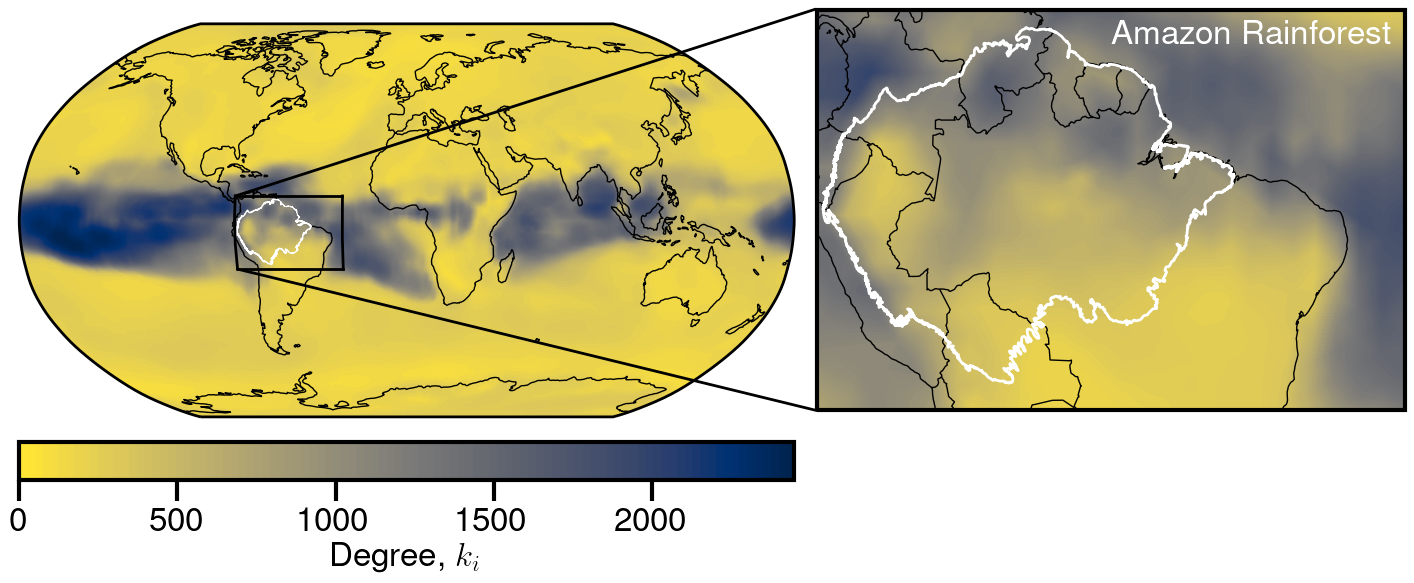

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition, inset_axes, zoomed_inset_axes, mark_inset
from shapely.geometry.polygon import LinearRing
import xarray as xr
# from affine import Affine
from glob import glob

aspect_ratio = (extent[1]-extent[0])/(extent[3]-extent[2])
lonmin, lonmax, latmin, latmax = extent

fontsize = 24

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig = plt.figure(figsize=(10, 8))
proj = ccrs.Robinson(central_longitude=0)
proj_cart = ccrs.PlateCarree()
ax1 = fig.add_subplot(1, 1, 1, projection=proj)
ax1.coastlines()

left, bottom, width, height = [.8, .35, .5*aspect_ratio, .5]
ax2 = fig.add_axes([left, bottom, width, height],
                   projection=ccrs.Robinson(central_longitude=(lonmin + lonmax) / 2))
ax2.set_extent(extent, crs=ccrs.PlateCarree())

# inset location relative to main plot (ax) in normalized units
inset_x = 1
inset_y = 1
inset_size = 0.2




ax2.coastlines()
ax2.add_feature(cartopy.feature.BORDERS)



nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
             np.linspace(lonmin, lonmax, nvert),
             np.linspace(lonmax, lonmax, nvert)].tolist()
lats = np.r_[np.linspace(latmin, latmax, nvert),
             np.linspace(latmax, latmax, nvert),
             np.linspace(latmax, latmin, nvert)].tolist()



max_degree = max(degrees)

num_levels = 100
# levels = np.arange(0,max_degree,5)
levels = np.linspace(0,max_degree,100)

im1 = ax1.contourf(ilon1, ilat1, idat1, levels=levels,
                  cmap='cividis_r', alpha=1,
                  vmin=0, vmax=max_degree,
                  transform=ccrs.PlateCarree())
for c in im1.collections:
    c.set_edgecolor("face")

# matches = glob(data_dir+'CD06_CAMREX_1086/*_v')
# matches = [match.split('\\')[-1] for match in matches]
# for match in matches:
#     reader = shpreader.Reader(data_dir+'CD06_CAMREX_1086/'+match+'/'+match+'.shp')
#     amazon = cartopy.feature.ShapelyFeature(list(reader.geometries()), ccrs.PlateCarree())
#     ax2.add_feature(amazon, facecolor='gray', edgecolor='gray', alpha=0.25)

reader = shpreader.Reader(base_dir+'Amazon Biome/amazonia.shp')
amazon = cartopy.feature.ShapelyFeature(list(reader.geometries()), ccrs.PlateCarree())
ax1.add_feature(amazon, facecolor='none', edgecolor='white', alpha=1, linewidth=1)
ax2.add_feature(amazon, facecolor='none', edgecolor='white', alpha=1, linewidth=2)
# ax2.add_feature(amazon, facecolor='gray', edgecolor='black', alpha=.25)

im2 = ax2.contourf(ilon2, ilat2, idat2, levels=levels,
                  cmap='cividis_r', alpha=1,
                  vmin=0, vmax=max_degree,
                  transform=ccrs.PlateCarree())
for c in im2.collections:
    c.set_edgecolor("face")


ax2.annotate(r'Amazon Rainforest', c='w', xy=(0.5,0.9), xycoords='axes fraction',
             fontsize=fontsize, ha='left', va='bottom')

cbar=plt.colorbar(im1, ax=ax1, orientation='horizontal',fraction=0.26, pad=0.04)
cbar.set_label(r'Degree, $k_i$',fontsize=fontsize)
cbar.set_ticks(np.arange(0,max_degree,500))  # vertically oriented colorbar

plt.setp(ax1.spines.values(), linewidth=2)
cbar.outline.set_linewidth(3)
cbar.ax.tick_params(length=15,width=3)

tick_locator = mpl.ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()

ticks = cbar.get_ticks()[:-1]
# multiplier = int('{:e}'.format(ticks[-1]).split('e')[1])
# fmt = MagnitudeFormatter(multiplier)
# cbar.ax.xaxis.set_major_formatter(fmt)
# # plt.ticklabel_format(style='sci', axis='y')
# # print(ax.yaxis.get_major_formatter().__dict__)
# cbar.ax.xaxis.offsetText.set_visible(False)

# print(yticks)
cbar.set_ticks(ticks)
cbar.set_ticklabels(['{:.0f}'.format(tick) for tick in ticks])

# if multiplier != 0:
#     cbar.ax.annotate(r'$\times 10^{'+str(multiplier)+r'}$', xy=(0.95,1.05), xycoords='axes fraction', ha='left', va='bottom', fontsize=fontsize)


coord_data_topleft_ax1 = proj.transform_point(lonmin,latmax,proj_cart)
coord_disp_topleft_ax1 = ax1.transData.transform(coord_data_topleft_ax1)
coord_axes_topleft_ax1 = ax1.transAxes.inverted().transform(coord_disp_topleft_ax1)

coord_data_botleft_ax1 = proj.transform_point(lonmin,latmin,proj_cart)
coord_disp_botleft_ax1 = ax1.transData.transform(coord_data_botleft_ax1)
coord_axes_botleft_ax1 = ax1.transAxes.inverted().transform(coord_disp_botleft_ax1)

coord_data_topright_ax1 = proj.transform_point(lonmax,latmax,proj_cart)
coord_disp_topright_ax1 = ax1.transData.transform(coord_data_topright_ax1)
coord_axes_topright_ax1 = ax1.transAxes.inverted().transform(coord_disp_topright_ax1)

coord_data_botright_ax1 = proj.transform_point(lonmax,latmin,proj_cart)
coord_disp_botright_ax1 = ax1.transData.transform(coord_data_botright_ax1)
coord_axes_botright_ax1 = ax1.transAxes.inverted().transform(coord_disp_botright_ax1)



ax2_pos = ax2.get_position(original=True)
coord_fig_topleft_ax2 = (ax2_pos.x0, ax2_pos.y1)
coord_disp_topleft_ax2 = fig.transFigure.transform(coord_fig_topleft_ax2)
coord_axes_topleft_ax2 = ax1.transAxes.inverted().transform(coord_disp_topleft_ax2)

coord_fig_botleft_ax2 = (ax2_pos.x0, ax2_pos.y0)
coord_disp_botleft_ax2 = fig.transFigure.transform(coord_fig_botleft_ax2)
coord_axes_botleft_ax2 = ax1.transAxes.inverted().transform(coord_disp_botleft_ax2)


plt.setp(ax2.spines.values(), linewidth=3)
# ax2.outline_patch.set_edgecolor('k')
# ax2.outline_patch.set_linewidth(3)
ring = LinearRing(list(zip(lons, lats)))
ax1.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='k', linewidth=0.75, zorder=5)
ax1.plot([coord_axes_topleft_ax1[0],coord_axes_topleft_ax2[0]+.155],
         [coord_axes_topleft_ax1[1],coord_axes_topleft_ax2[1]+.092],
         'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)
ax1.plot([coord_axes_botleft_ax1[0],coord_axes_botleft_ax2[0]+.157],
         [coord_axes_botleft_ax1[1],coord_axes_botleft_ax2[1]],
         'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)

ax1.plot([lonmin,lonmax], [latmax,latmax], 'k', transform=ccrs.PlateCarree(),
         zorder=5, lw=2)
ax1.plot([lonmax,lonmax], [latmax,latmin], 'k', transform=ccrs.PlateCarree(),
         zorder=5, lw=2)
ax1.plot([lonmax,lonmin], [latmin,latmin], 'k', transform=ccrs.PlateCarree(),
         zorder=5, lw=2)
ax1.plot([lonmin,lonmin], [latmin,latmax], 'k', transform=ccrs.PlateCarree(),
         zorder=5, lw=2)

# ax1.plot([coord_axes_topleft_ax1[0],coord_data_topright_ax1[0]],
#          [coord_axes_topleft_ax1[1],coord_data_topright_ax1[1]],
#          'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)
# ax1.plot([coord_data_topright_ax1[0],coord_data_botright_ax1[0]],
#          [coord_data_topright_ax1[1],coord_data_botright_ax1[1]],
#          'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)
# ax1.plot([coord_data_botright_ax1[0],coord_data_botleft_ax1[0]],
#          [coord_data_botright_ax1[1],coord_data_botleft_ax1[1]],
#          'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)
# ax1.plot([coord_data_botleft_ax1[0],coord_data_topleft_ax1[0]],
#          [coord_data_botleft_ax1[1],coord_data_topleft_ax1[1]],
#          'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)


# plt.tight_layout()




title = 'Degree'
# plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
# plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2)
# plt.savefig(fig_dir+title+'.eps',bbox_inches='tight',pad_inches=0.2)
plt.show()
plt.close(fig)

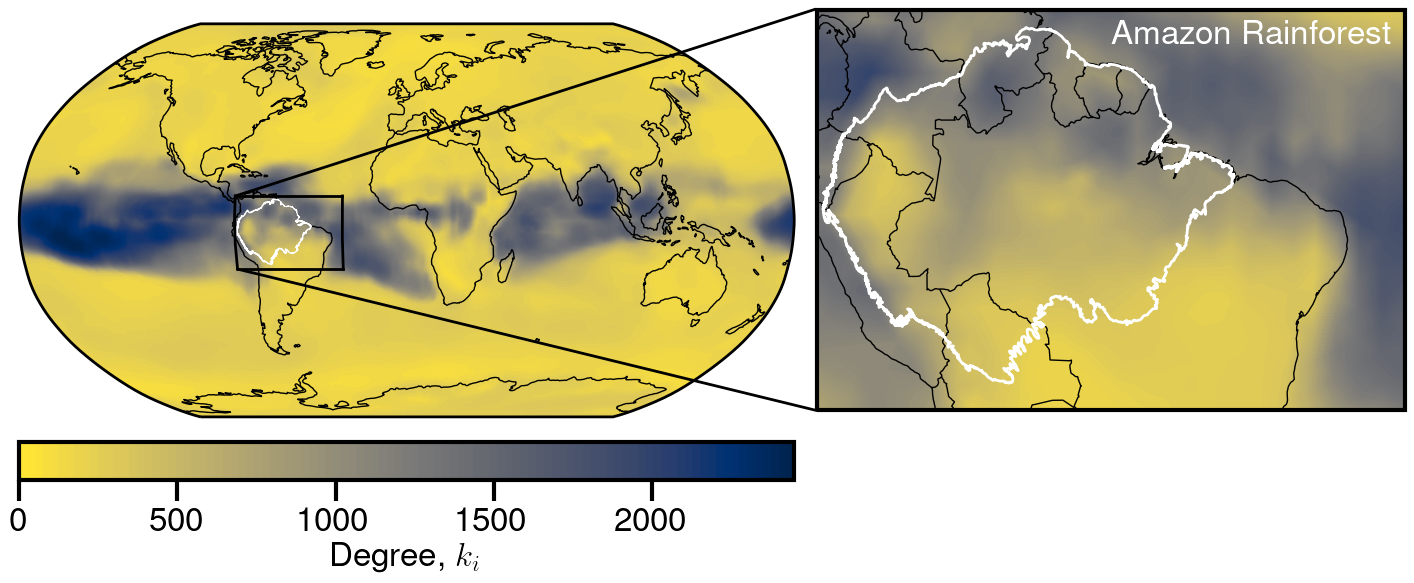

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition, inset_axes, zoomed_inset_axes, mark_inset
from shapely.geometry.polygon import LinearRing
import xarray as xr
# from affine import Affine
from glob import glob

aspect_ratio = (extent[1]-extent[0])/(extent[3]-extent[2])
lonmin, lonmax, latmin, latmax = extent

fontsize = 24

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig = plt.figure(figsize=(10, 8))
proj = ccrs.Robinson(central_longitude=0)
proj_cart = ccrs.PlateCarree()
ax1 = fig.add_subplot(1, 1, 1, projection=proj)
ax1.coastlines()

left, bottom, width, height = [.8, .35, .5*aspect_ratio, .5]
ax2 = fig.add_axes([left, bottom, width, height],
                   projection=ccrs.Robinson(central_longitude=(lonmin + lonmax) / 2))
ax2.set_extent(extent, crs=ccrs.PlateCarree())

# inset location relative to main plot (ax) in normalized units
inset_x = 1
inset_y = 1
inset_size = 0.2




ax2.coastlines()
ax2.add_feature(cartopy.feature.BORDERS)



nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
             np.linspace(lonmin, lonmax, nvert),
             np.linspace(lonmax, lonmax, nvert)].tolist()
lats = np.r_[np.linspace(latmin, latmax, nvert),
             np.linspace(latmax, latmax, nvert),
             np.linspace(latmax, latmin, nvert)].tolist()



max_degree = max(degrees)

num_levels = 100
# levels = np.arange(0,max_degree,5)
levels = np.linspace(0,max_degree,100)

im1 = ax1.contourf(ilon1, ilat1, idat1, levels=levels,
                  cmap='cividis_r', alpha=1,
                  vmin=0, vmax=max_degree, zorder=-20,
                  transform=ccrs.PlateCarree())
for c in im1.collections:
    c.set_edgecolor("face")
ax1.set_rasterization_zorder(-10)

# matches = glob(data_dir+'CD06_CAMREX_1086/*_v')
# matches = [match.split('\\')[-1] for match in matches]
# for match in matches:
#     reader = shpreader.Reader(data_dir+'CD06_CAMREX_1086/'+match+'/'+match+'.shp')
#     amazon = cartopy.feature.ShapelyFeature(list(reader.geometries()), ccrs.PlateCarree())
#     ax2.add_feature(amazon, facecolor='gray', edgecolor='gray', alpha=0.25)

reader = shpreader.Reader(base_dir+'Amazon Biome/amazonia.shp')
amazon = cartopy.feature.ShapelyFeature(list(reader.geometries()), ccrs.PlateCarree())
ax1.add_feature(amazon, facecolor='none', edgecolor='white', alpha=1, linewidth=1)
ax2.add_feature(amazon, facecolor='none', edgecolor='white', alpha=1, linewidth=2)
# ax2.add_feature(amazon, facecolor='gray', edgecolor='black', alpha=.25)

im2 = ax2.contourf(ilon2, ilat2, idat2, levels=levels,
                  cmap='cividis_r', alpha=1,
                  vmin=0, vmax=max_degree, zorder=-20,
                  transform=ccrs.PlateCarree())
for c in im2.collections:
    c.set_edgecolor("face")
ax2.set_rasterization_zorder(-10)


ax2.annotate(r'Amazon Rainforest', c='w', xy=(0.5,0.9), xycoords='axes fraction',
             fontsize=fontsize, ha='left', va='bottom')

cbar=plt.colorbar(im1, ax=ax1, orientation='horizontal',fraction=0.26, pad=0.04)
cbar.set_label(r'Degree, $k_i$',fontsize=fontsize)
cbar.set_ticks(np.arange(0,max_degree,500))  # vertically oriented colorbar

plt.setp(ax1.spines.values(), linewidth=2)
cbar.outline.set_linewidth(3)
cbar.ax.tick_params(length=15,width=3)

tick_locator = mpl.ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()

ticks = cbar.get_ticks()[:-1]
# multiplier = int('{:e}'.format(ticks[-1]).split('e')[1])
# fmt = MagnitudeFormatter(multiplier)
# cbar.ax.xaxis.set_major_formatter(fmt)
# # plt.ticklabel_format(style='sci', axis='y')
# # print(ax.yaxis.get_major_formatter().__dict__)
# cbar.ax.xaxis.offsetText.set_visible(False)

# print(yticks)
cbar.set_ticks(ticks)
cbar.set_ticklabels(['{:.0f}'.format(tick) for tick in ticks])

# if multiplier != 0:
#     cbar.ax.annotate(r'$\times 10^{'+str(multiplier)+r'}$', xy=(0.95,1.05), xycoords='axes fraction', ha='left', va='bottom', fontsize=fontsize)


coord_data_topleft_ax1 = proj.transform_point(lonmin,latmax,proj_cart)
coord_disp_topleft_ax1 = ax1.transData.transform(coord_data_topleft_ax1)
coord_axes_topleft_ax1 = ax1.transAxes.inverted().transform(coord_disp_topleft_ax1)

coord_data_botleft_ax1 = proj.transform_point(lonmin,latmin,proj_cart)
coord_disp_botleft_ax1 = ax1.transData.transform(coord_data_botleft_ax1)
coord_axes_botleft_ax1 = ax1.transAxes.inverted().transform(coord_disp_botleft_ax1)

coord_data_topright_ax1 = proj.transform_point(lonmax,latmax,proj_cart)
coord_disp_topright_ax1 = ax1.transData.transform(coord_data_topright_ax1)
coord_axes_topright_ax1 = ax1.transAxes.inverted().transform(coord_disp_topright_ax1)

coord_data_botright_ax1 = proj.transform_point(lonmax,latmin,proj_cart)
coord_disp_botright_ax1 = ax1.transData.transform(coord_data_botright_ax1)
coord_axes_botright_ax1 = ax1.transAxes.inverted().transform(coord_disp_botright_ax1)



ax2_pos = ax2.get_position(original=True)
coord_fig_topleft_ax2 = (ax2_pos.x0, ax2_pos.y1)
coord_disp_topleft_ax2 = fig.transFigure.transform(coord_fig_topleft_ax2)
coord_axes_topleft_ax2 = ax1.transAxes.inverted().transform(coord_disp_topleft_ax2)

coord_fig_botleft_ax2 = (ax2_pos.x0, ax2_pos.y0)
coord_disp_botleft_ax2 = fig.transFigure.transform(coord_fig_botleft_ax2)
coord_axes_botleft_ax2 = ax1.transAxes.inverted().transform(coord_disp_botleft_ax2)


plt.setp(ax2.spines.values(), linewidth=3)
# ax2.outline_patch.set_edgecolor('k')
# ax2.outline_patch.set_linewidth(3)
ring = LinearRing(list(zip(lons, lats)))
ax1.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='k', linewidth=0.75, zorder=5)
ax1.plot([coord_axes_topleft_ax1[0],coord_axes_topleft_ax2[0]+.155],
         [coord_axes_topleft_ax1[1],coord_axes_topleft_ax2[1]+.092],
         'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)
ax1.plot([coord_axes_botleft_ax1[0],coord_axes_botleft_ax2[0]+.157],
         [coord_axes_botleft_ax1[1],coord_axes_botleft_ax2[1]],
         'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)

ax1.plot([lonmin,lonmax], [latmax,latmax], 'k', transform=ccrs.PlateCarree(),
         zorder=5, lw=2)
ax1.plot([lonmax,lonmax], [latmax,latmin], 'k', transform=ccrs.PlateCarree(),
         zorder=5, lw=2)
ax1.plot([lonmax,lonmin], [latmin,latmin], 'k', transform=ccrs.PlateCarree(),
         zorder=5, lw=2)
ax1.plot([lonmin,lonmin], [latmin,latmax], 'k', transform=ccrs.PlateCarree(),
         zorder=5, lw=2)

# ax1.plot([coord_axes_topleft_ax1[0],coord_data_topright_ax1[0]],
#          [coord_axes_topleft_ax1[1],coord_data_topright_ax1[1]],
#          'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)
# ax1.plot([coord_data_topright_ax1[0],coord_data_botright_ax1[0]],
#          [coord_data_topright_ax1[1],coord_data_botright_ax1[1]],
#          'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)
# ax1.plot([coord_data_botright_ax1[0],coord_data_botleft_ax1[0]],
#          [coord_data_botright_ax1[1],coord_data_botleft_ax1[1]],
#          'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)
# ax1.plot([coord_data_botleft_ax1[0],coord_data_topleft_ax1[0]],
#          [coord_data_botleft_ax1[1],coord_data_topleft_ax1[1]],
#          'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)


# plt.tight_layout()




title = 'Degree (Rasterized)'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2)
plt.savefig(fig_dir+title+'.eps',bbox_inches='tight',pad_inches=0.2)
plt.show()
plt.close(fig)

In [47]:
with gzip.open(data_dir + 'R_i_dict_vary_density.data', 'rb') as file:
    R_i_dict_vary_density = pkl.load(file)

In [31]:
R_i_dict_vary_density[density][dates[0]]

array([0., 0., 0., ..., 0., 0., 0.])

In [48]:
ilat1, ilon1, idat1 = interpolate_scatter_data(latlon_icos, list(R_i_dict_vary_density[density][dates[0]]),
                                               method='linear', num_interp_pts=200,
                                               threshold_dateline=5,
                                               threshold_poles=15)


extent = [-80+360, -30+360, -20, 10]
filler = 1
ilat2, ilon2, idat2 = interpolate_scatter_data(latlon_icos, list(R_i_dict_vary_density[density][dates[0]]),
                                               method='linear', num_interp_pts=200,
                                               threshold_dateline=5,
                                               threshold_poles=15,
                                               extent=extent, filler=filler)

Replacing Dateline:   0%|          | 0/1200 [00:00<?, ?it/s]

Replacing Poles:   0%|          | 0/6800 [00:00<?, ?it/s]

Replacing NaNs: 0it [00:00, ?it/s]

Replacing Dateline: 0it [00:00, ?it/s]

Replacing Poles: 0it [00:00, ?it/s]

Replacing NaNs: 0it [00:00, ?it/s]

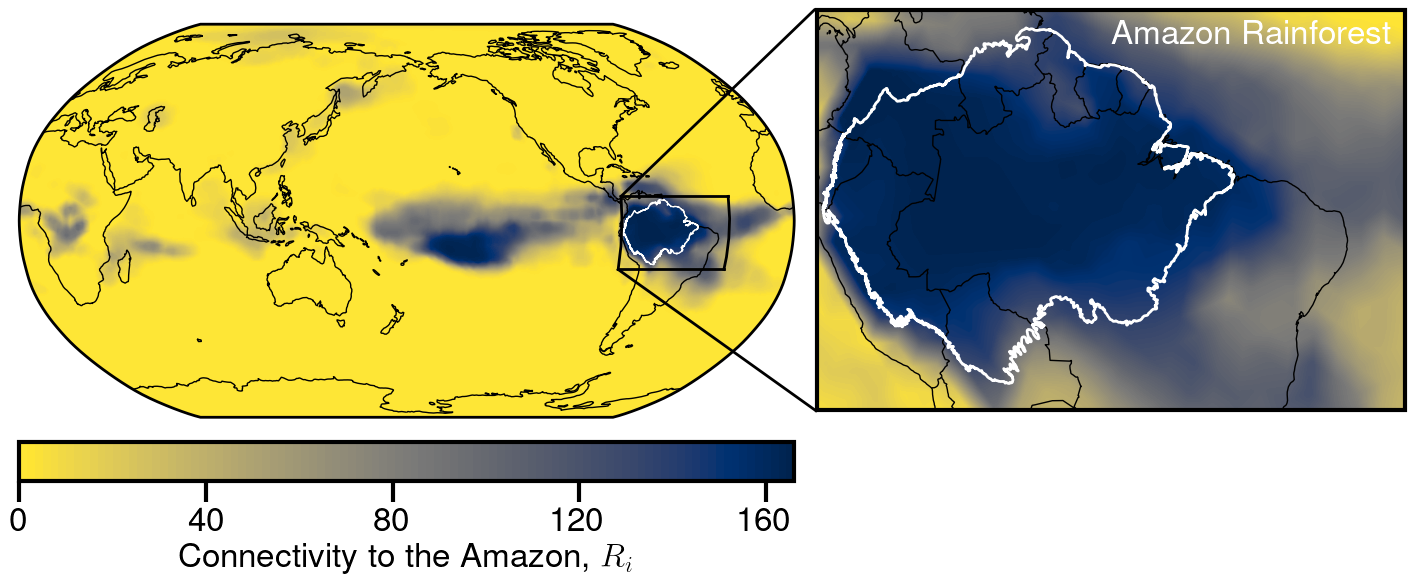

In [49]:
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition, inset_axes, zoomed_inset_axes, mark_inset
from shapely.geometry.polygon import LinearRing
import xarray as xr
# from affine import Affine
from glob import glob

aspect_ratio = (extent[1]-extent[0])/(extent[3]-extent[2])
lonmin, lonmax, latmin, latmax = extent

fontsize = 24

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig = plt.figure(figsize=(10, 8))
proj = ccrs.Robinson(central_longitude=180)
proj_cart = ccrs.PlateCarree()
ax1 = fig.add_subplot(1, 1, 1, projection=proj)
ax1.coastlines()

left, bottom, width, height = [.8, .35, .5*aspect_ratio, .5]
ax2 = fig.add_axes([left, bottom, width, height],
                   projection=ccrs.Robinson(central_longitude=(lonmin + lonmax) / 2))
ax2.set_extent(extent, crs=ccrs.PlateCarree())

# inset location relative to main plot (ax) in normalized units
inset_x = 1
inset_y = 1
inset_size = 0.2




ax2.coastlines()
ax2.add_feature(cartopy.feature.BORDERS)



nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
             np.linspace(lonmin, lonmax, nvert),
             np.linspace(lonmax, lonmax, nvert)].tolist()
lats = np.r_[np.linspace(latmin, latmax, nvert),
             np.linspace(latmax, latmax, nvert),
             np.linspace(latmax, latmin, nvert)].tolist()



max_degree = max(R_i_dict_vary_density[density][dates[0]])

num_levels = 100
# levels = np.arange(0,max_degree,5)
levels = np.linspace(0,max_degree,100)

im1 = ax1.contourf(ilon1, ilat1, idat1, levels=levels,
                  cmap='cividis_r', alpha=1,
                  vmin=0, vmax=max_degree, zorder=-20,
                  transform=ccrs.PlateCarree())
for c in im1.collections:
    c.set_edgecolor("face")
ax1.set_rasterization_zorder(-10)

# matches = glob(data_dir+'CD06_CAMREX_1086/*_v')
# matches = [match.split('\\')[-1] for match in matches]
# for match in matches:
#     reader = shpreader.Reader(data_dir+'CD06_CAMREX_1086/'+match+'/'+match+'.shp')
#     amazon = cartopy.feature.ShapelyFeature(list(reader.geometries()), ccrs.PlateCarree())
#     ax2.add_feature(amazon, facecolor='gray', edgecolor='gray', alpha=0.25)

reader = shpreader.Reader(base_dir+'Amazon Biome/amazonia.shp')
amazon = cartopy.feature.ShapelyFeature(list(reader.geometries()), ccrs.PlateCarree())
ax1.add_feature(amazon, facecolor='none', edgecolor='white', alpha=1, linewidth=1)
ax2.add_feature(amazon, facecolor='none', edgecolor='white', alpha=1, linewidth=2)
# ax2.add_feature(amazon, facecolor='gray', edgecolor='black', alpha=.25)

im2 = ax2.contourf(ilon2, ilat2, idat2, levels=levels,
                  cmap='cividis_r', alpha=1,
                  vmin=0, vmax=max_degree, zorder=-20,
                  transform=ccrs.PlateCarree())
for c in im2.collections:
    c.set_edgecolor("face")
ax2.set_rasterization_zorder(-10)


ax2.annotate(r'Amazon Rainforest', c='w', xy=(0.5,0.9), xycoords='axes fraction',
             fontsize=fontsize, ha='left', va='bottom')

cbar=plt.colorbar(im1, ax=ax1, orientation='horizontal',fraction=0.26, pad=0.04)
cbar.set_label(r'Connectivity to the Amazon, $R_i$',fontsize=fontsize)
cbar.set_ticks(np.arange(0,max_degree,500))  # vertically oriented colorbar

plt.setp(ax1.spines.values(), linewidth=2)
cbar.outline.set_linewidth(3)
cbar.ax.tick_params(length=15,width=3)

tick_locator = mpl.ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()

ticks = cbar.get_ticks()[:-1]
# multiplier = int('{:e}'.format(ticks[-1]).split('e')[1])
# fmt = MagnitudeFormatter(multiplier)
# cbar.ax.xaxis.set_major_formatter(fmt)
# # plt.ticklabel_format(style='sci', axis='y')
# # print(ax.yaxis.get_major_formatter().__dict__)
# cbar.ax.xaxis.offsetText.set_visible(False)

# print(yticks)
cbar.set_ticks(ticks)
cbar.set_ticklabels(['{:.0f}'.format(tick) for tick in ticks])

# if multiplier != 0:
#     cbar.ax.annotate(r'$\times 10^{'+str(multiplier)+r'}$', xy=(0.95,1.05), xycoords='axes fraction', ha='left', va='bottom', fontsize=fontsize)


coord_data_topleft_ax1 = proj.transform_point(lonmin,latmax,proj_cart)
coord_disp_topleft_ax1 = ax1.transData.transform(coord_data_topleft_ax1)
coord_axes_topleft_ax1 = ax1.transAxes.inverted().transform(coord_disp_topleft_ax1)

coord_data_botleft_ax1 = proj.transform_point(lonmin,latmin,proj_cart)
coord_disp_botleft_ax1 = ax1.transData.transform(coord_data_botleft_ax1)
coord_axes_botleft_ax1 = ax1.transAxes.inverted().transform(coord_disp_botleft_ax1)

coord_data_topright_ax1 = proj.transform_point(lonmax,latmax,proj_cart)
coord_disp_topright_ax1 = ax1.transData.transform(coord_data_topright_ax1)
coord_axes_topright_ax1 = ax1.transAxes.inverted().transform(coord_disp_topright_ax1)

coord_data_botright_ax1 = proj.transform_point(lonmax,latmin,proj_cart)
coord_disp_botright_ax1 = ax1.transData.transform(coord_data_botright_ax1)
coord_axes_botright_ax1 = ax1.transAxes.inverted().transform(coord_disp_botright_ax1)



ax2_pos = ax2.get_position(original=True)
coord_fig_topleft_ax2 = (ax2_pos.x0, ax2_pos.y1)
coord_disp_topleft_ax2 = fig.transFigure.transform(coord_fig_topleft_ax2)
coord_axes_topleft_ax2 = ax1.transAxes.inverted().transform(coord_disp_topleft_ax2)

coord_fig_botleft_ax2 = (ax2_pos.x0, ax2_pos.y0)
coord_disp_botleft_ax2 = fig.transFigure.transform(coord_fig_botleft_ax2)
coord_axes_botleft_ax2 = ax1.transAxes.inverted().transform(coord_disp_botleft_ax2)


plt.setp(ax2.spines.values(), linewidth=3)
# ax2.outline_patch.set_edgecolor('k')
# ax2.outline_patch.set_linewidth(3)
ring = LinearRing(list(zip(lons, lats)))
ax1.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='k', linewidth=0.75, zorder=5)
ax1.plot([coord_axes_topleft_ax1[0],coord_axes_topleft_ax2[0]+.155],
         [coord_axes_topleft_ax1[1],coord_axes_topleft_ax2[1]+.092],
         'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)
ax1.plot([coord_axes_botleft_ax1[0],coord_axes_botleft_ax2[0]+.157],
         [coord_axes_botleft_ax1[1],coord_axes_botleft_ax2[1]],
         'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)

ax1.plot([lonmin,lonmax], [latmax,latmax], 'k', transform=ccrs.PlateCarree(),
         zorder=5, lw=2)
ax1.plot([lonmax,lonmax], [latmax,latmin], 'k', transform=ccrs.PlateCarree(),
         zorder=5, lw=2)
ax1.plot([lonmax,lonmin], [latmin,latmin], 'k', transform=ccrs.PlateCarree(),
         zorder=5, lw=2)
ax1.plot([lonmin,lonmin], [latmin,latmax], 'k', transform=ccrs.PlateCarree(),
         zorder=5, lw=2)

# ax1.plot([coord_axes_topleft_ax1[0],coord_data_topright_ax1[0]],
#          [coord_axes_topleft_ax1[1],coord_data_topright_ax1[1]],
#          'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)
# ax1.plot([coord_data_topright_ax1[0],coord_data_botright_ax1[0]],
#          [coord_data_topright_ax1[1],coord_data_botright_ax1[1]],
#          'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)
# ax1.plot([coord_data_botright_ax1[0],coord_data_botleft_ax1[0]],
#          [coord_data_botright_ax1[1],coord_data_botleft_ax1[1]],
#          'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)
# ax1.plot([coord_data_botleft_ax1[0],coord_data_topleft_ax1[0]],
#          [coord_data_botleft_ax1[1],coord_data_topleft_ax1[1]],
#          'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)


# plt.tight_layout()




title = 'R_i (Rasterized)'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2)
plt.savefig(fig_dir+title+'.eps',bbox_inches='tight',pad_inches=0.2)
plt.show()
plt.close(fig)

In [50]:
with gzip.open(data_dir + 'amazon_nodes_new_networks.data', 'rb') as file:
    amazon_nodes = pkl.load(file)

In [51]:
R_i_dict_vary_density[density] = {date:np.array(R_i_dict_vary_density[density][date])/len(amazon_nodes) for date in dates}

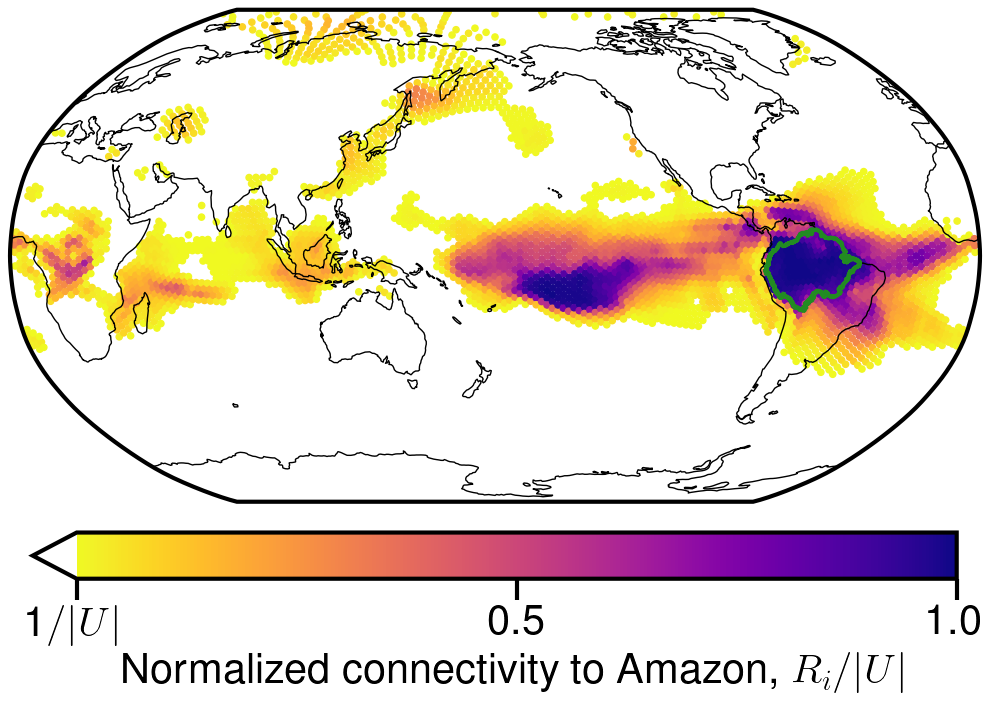

In [61]:
densities = [0.05]

n = 1
# spacing = min([int(round(len(dates)/2)/(n//2)),int((len(dates)-1 - round(len(dates)/2))/(n//2))])
middle = round(len(dates)/2)
print()
dates_to_plot = [dates[0]]
# dates_to_plot = ['1948-1973', '1950-1975', '1970-1995', '1993-2018', '1995-2020']

max_value = 0
for density in densities:
  for date in dates_to_plot:
    max_value = max([max_value,max(R_i_dict_vary_density[density][date])])



fontsize = 30

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

# serif_font = fm.FontProperties(fname=font_dir+'cmr10.ttf', size=fontsize, math_fontfamily='cm')
# fpath = Path(font_dir+'cmr10.ttf')

fig = plt.figure(figsize=(10*len(densities),8*len(dates_to_plot)))

for j in range(len(densities)):
  density = densities[j]
  for i in range(len(dates_to_plot)):
    date = dates_to_plot[i]
    title = datetime.strptime(date_intervals[dates.index(date)][0], '%m/%d/%Y').strftime('%b %d, %Y') + ' - ' + datetime.strptime(date_intervals[dates.index(date)][1], '%m/%d/%Y').strftime('%b %d, %Y')


    R_i_dict_vary_density[density][date] = np.array(R_i_dict_vary_density[density][date])



  #   latlon_icos = np.hstack((finallats_dict[date],finallons_dict[date]))
  #   ilat, ilon, idat = interpolate_scatter_data(latlon_icos, R_i_dict_vary_density[density][date],
  # #                      shape_filename=base_dir+'/Amazon Biome/amazonia.shp',
  #                      method='linear', num_interp_pts=200, threshold_dateline=5, threshold_poles=15)

    ax = plt.subplot2grid(shape=(len(dates_to_plot), len(densities)), loc=(i, j), projection=ccrs.Robinson(central_longitude=180))

    ax.coastlines(zorder=5)

    min_value = 1/len(amazon_nodes)

    levels = np.linspace(min_value,max_value,100)
    ticks = [(levels[i]+levels[i+1])/2 for i in range(len(levels)-1)]

    cmap = mpl.cm.plasma_r


    reader = shpreader.Reader(base_dir+'/Amazon Biome/amazonia.shp')
    amazon = cartopy.feature.ShapelyFeature(list(reader.geometries()), ccrs.PlateCarree())
    ax.add_feature(amazon, facecolor='none', edgecolor='forestgreen', alpha=1, linewidth=3, zorder=6)



    ind = np.where(R_i_dict_vary_density[density][date] > 0)[0]

    # idat[idat < min_value] = np.NAN

    # im = ax.contourf(ilon, ilat, idat, levels=levels,
    #                   cmap=cmap, alpha=1,
    #                   vmin=min_value, vmax=max_value,
    #                   transform=ccrs.PlateCarree(), zorder=4)
    im = ax.scatter(latlon_icos[ind,1], latlon_icos[ind,0],
                    c=R_i_dict_vary_density[density][date][ind],
                    cmap='plasma_r', transform=ccrs.PlateCarree(), marker='o', s=20,
                    edgecolors=None, zorder=-20)
    ax.scatter(latlon_icos[:,1], latlon_icos[:,0],
               c=R_i_dict_vary_density[density][date][:],
               cmap='plasma_r', transform=ccrs.PlateCarree(), marker='o', s=0,
               edgecolors=None, zorder=-15, alpha=0)
    # ax.set_extent([-180,180,-90,90], crs=ccrs.PlateCarree())
    # for c in im.collections:
    #     c.set_edgecolor("face")
    im.set_clim(min_value, max_value)
    ax.set_rasterization_zorder(-10)

    im.cmap.set_under('w')

    # ax.annotate(r'\textbf{('+chr(97+i + j*len(dates_to_plot))+')}', xy=(0, 1), xycoords="axes fraction",
    #             fontsize=fontsize,usetex=True, va='top', ha='left')

    # ax.set_title(title, fontsize=fontsize)

    plt.setp(ax.spines.values(), linewidth=3, zorder=100)
    ax.tick_params(length=15,width=3)

    # if i == len(dates_to_plot) - 1:
    #   ax.annotate(r'$\rho = {:}$'.format(density), xy=(0.5,-0.05), va='top', ha='center', xycoords='axes fraction', fontsize=fontsize)


plt.tight_layout()
plt.subplots_adjust(hspace = 0.2, wspace = -0.4)

cbar = fig.colorbar(im, ax = fig.get_axes(), anchor=(0.468, 0),
                    orientation='horizontal',fraction=0.06, pad=0.04,
                    extend='min')
ticks = np.linspace(min_value,max_value,3)
cbar.set_ticks(ticks)
cbar.set_ticklabels(['{:.1f}'.format(ticks[i]) if i>0 else r'1$/|U|$' for i in range(len(ticks))],usetex=True)
# cbar.set_ticklabels(['{:.1f}'.format(ticks[i]) for i in range(len(ticks))],usetex=True)






# cbar=plt.colorbar(im, ax=ax, ticks=ticks[1::3], fraction=0.048, orientation='horizontal',
#                   pad=0.02, boundaries=levels)
# cbar.set_ticklabels(['{:.4f}'.format(tick) for tick in ticks[1::3]])

# cbar.set_label('Slope of Trendline of Average Diffusion Distance to Amazon\n$t = $ '+
#                '{:.4f}'.format(round(t_target, 4)),fontsize=fontsize)
cbar.set_label(r'Normalized connectivity to Amazon, $R_{i}/|U|$',fontsize=fontsize)

cbar.outline.set_linewidth(3)
cbar.ax.tick_params(length=15,width=3)

title = 'Amazon Connectivity (Scatter)'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2)
plt.savefig(fig_dir+title+'.eps',bbox_inches='tight',pad_inches=0.2)
plt.show()
plt.close(fig)

In [91]:
extent = [-85+360, -25+360, -20, 12]
filler = 1
ilat2, ilon2, idat2 = interpolate_scatter_data(latlon_icos, list(R_i_dict_vary_density[density][dates[0]]),
                                               method='linear', num_interp_pts=200,
                                               threshold_dateline=5,
                                               threshold_poles=15,
                                               extent=extent, filler=filler)

Replacing Dateline: 0it [00:00, ?it/s]

Replacing Poles: 0it [00:00, ?it/s]

Replacing NaNs: 0it [00:00, ?it/s]

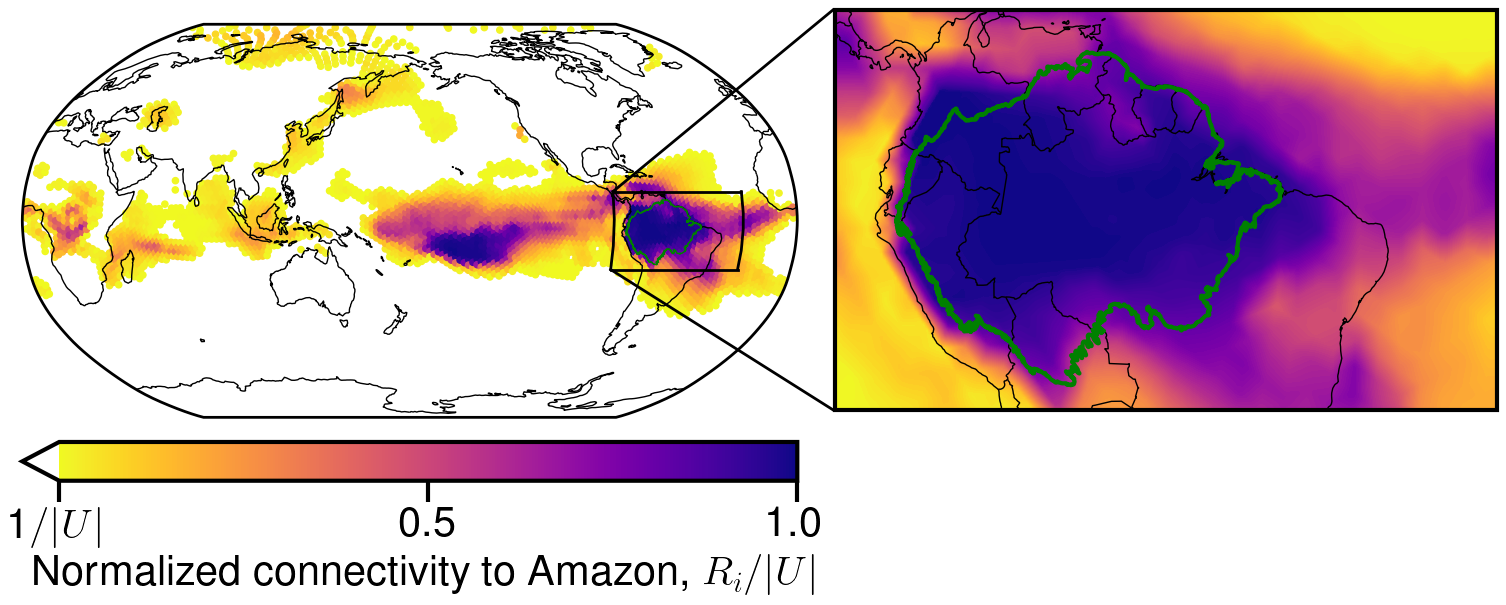

In [94]:
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition, inset_axes, zoomed_inset_axes, mark_inset
from shapely.geometry.polygon import LinearRing
import xarray as xr
# from affine import Affine
from glob import glob

aspect_ratio = (extent[1]-extent[0])/(extent[3]-extent[2])
lonmin, lonmax, latmin, latmax = extent

fontsize = 30

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig = plt.figure(figsize=(10, 8))
proj = ccrs.Robinson(central_longitude=180)
proj_cart = ccrs.PlateCarree()
ax1 = fig.add_subplot(1, 1, 1, projection=proj)
ax1.coastlines()

left, bottom, width, height = [.8, .35, .5*aspect_ratio, .5]
ax2 = fig.add_axes([left, bottom, width, height],
                   projection=ccrs.Robinson(central_longitude=(lonmin + lonmax) / 2))
ax2.set_extent(extent, crs=ccrs.PlateCarree())

# inset location relative to main plot (ax) in normalized units
inset_x = 1
inset_y = 1
inset_size = 0.2




ax2.coastlines()
ax2.add_feature(cartopy.feature.BORDERS)



nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
             np.linspace(lonmin, lonmax, nvert),
             np.linspace(lonmax, lonmax, nvert)].tolist()
lats = np.r_[np.linspace(latmin, latmax, nvert),
             np.linspace(latmax, latmax, nvert),
             np.linspace(latmax, latmin, nvert)].tolist()



max_degree = max(R_i_dict_vary_density[density][dates[0]])

num_levels = 100
# levels = np.arange(0,max_degree,5)
levels = np.linspace(0,max_degree,100)

im1 = ax1.scatter(latlon_icos[ind,1], latlon_icos[ind,0],
                c=R_i_dict_vary_density[density][date][ind],
                cmap='plasma_r', transform=ccrs.PlateCarree(), marker='o', s=20,
                edgecolors=None, zorder=-20)
ax1.scatter(latlon_icos[:,1], latlon_icos[:,0],
            c=R_i_dict_vary_density[density][date][:],
            cmap='plasma_r', transform=ccrs.PlateCarree(), marker='o', s=0,
            edgecolors=None, zorder=-15, alpha=0)
# ax1.set_extent([-180,180,-90,90], crs=ccrs.PlateCarree())
# for c in im.collections:
#     c.set_edgecolor("face")
im1.set_clim(min_value, max_value)
ax1.set_rasterization_zorder(-10)

im1.cmap.set_under('w')

# im1 = ax1.contourf(ilon1, ilat1, idat1, levels=levels,
#                   cmap='cividis_r', alpha=1,
#                   vmin=0, vmax=max_degree, zorder=-20,
#                   transform=ccrs.PlateCarree())
# for c in im1.collections:
#     c.set_edgecolor("face")
# ax1.set_rasterization_zorder(-10)

# matches = glob(data_dir+'CD06_CAMREX_1086/*_v')
# matches = [match.split('\\')[-1] for match in matches]
# for match in matches:
#     reader = shpreader.Reader(data_dir+'CD06_CAMREX_1086/'+match+'/'+match+'.shp')
#     amazon = cartopy.feature.ShapelyFeature(list(reader.geometries()), ccrs.PlateCarree())
#     ax2.add_feature(amazon, facecolor='gray', edgecolor='gray', alpha=0.25)

reader = shpreader.Reader(base_dir+'Amazon Biome/amazonia.shp')
amazon = cartopy.feature.ShapelyFeature(list(reader.geometries()), ccrs.PlateCarree())
ax1.add_feature(amazon, facecolor='none', edgecolor='g', alpha=1, linewidth=1)
ax2.add_feature(amazon, facecolor='none', edgecolor='g', alpha=1, linewidth=3)
# ax2.add_feature(amazon, facecolor='gray', edgecolor='black', alpha=.25)

im2 = ax2.contourf(ilon2, ilat2, idat2, levels=levels,
                  cmap='plasma_r', alpha=1,
                  vmin=0, vmax=max_degree, zorder=-20,
                  transform=ccrs.PlateCarree())
for c in im2.collections:
    c.set_edgecolor("face")
ax2.set_rasterization_zorder(-10)

# im2 = ax2.scatter(latlon_icos[ind,1], latlon_icos[ind,0],
#                 c=R_i_dict_vary_density[density][date][ind],
#                 cmap='plasma_r', transform=ccrs.PlateCarree(), marker='o', s=100,
#                 edgecolors=None, zorder=-20)
# # ax2.scatter(latlon_icos[:,1], latlon_icos[:,0],
# #             c=R_i_dict_vary_density[density][date][:],
# #             cmap='plasma_r', transform=ccrs.PlateCarree(), marker='o', s=0,
# #             edgecolors=None, zorder=-15, alpha=0)
# # ax2.set_extent([-180,180,-90,90], crs=ccrs.PlateCarree())
# # for c in im.collections:
# #     c.set_edgecolor("face")
# im2.set_clim(min_value, max_value)
# ax2.set_rasterization_zorder(-10)

# im2.cmap.set_under('w')


# ax2.annotate(r'Amazon Rainforest', c='g', xy=(0.98,0.98), xycoords='axes fraction',
#              fontsize=fontsize, ha='right', va='top')

cbar=plt.colorbar(im1, ax=ax1, orientation='horizontal',fraction=0.26, pad=0.04, extend='min')
cbar.set_label(r'Normalized connectivity to Amazon, $R_{i}/|U|$',fontsize=fontsize)


min_value, max_value = 1/len(amazon_nodes), max(R_i_dict_vary_density[density][date])

ticks = np.linspace(min_value,max_value,3)
cbar.set_ticks(ticks)
cbar.set_ticklabels(['{:.1f}'.format(ticks[i]) if i>0 else r'1$/|U|$' for i in range(len(ticks))],usetex=True)


plt.setp(ax1.spines.values(), linewidth=2)
cbar.outline.set_linewidth(3)
cbar.ax.tick_params(length=15,width=3)

# tick_locator = mpl.ticker.MaxNLocator(nbins=5)
# cbar.locator = tick_locator
# cbar.update_ticks()

# ticks = cbar.get_ticks()[:-1]
# # multiplier = int('{:e}'.format(ticks[-1]).split('e')[1])
# # fmt = MagnitudeFormatter(multiplier)
# # cbar.ax.xaxis.set_major_formatter(fmt)
# # # plt.ticklabel_format(style='sci', axis='y')
# # # print(ax.yaxis.get_major_formatter().__dict__)
# # cbar.ax.xaxis.offsetText.set_visible(False)

# # print(yticks)
# cbar.set_ticks(ticks)
# cbar.set_ticklabels(['{:.0f}'.format(tick) for tick in ticks])

# if multiplier != 0:
#     cbar.ax.annotate(r'$\times 10^{'+str(multiplier)+r'}$', xy=(0.95,1.05), xycoords='axes fraction', ha='left', va='bottom', fontsize=fontsize)


coord_data_topleft_ax1 = proj.transform_point(lonmin,latmax,proj_cart)
coord_disp_topleft_ax1 = ax1.transData.transform(coord_data_topleft_ax1)
coord_axes_topleft_ax1 = ax1.transAxes.inverted().transform(coord_disp_topleft_ax1)

coord_data_botleft_ax1 = proj.transform_point(lonmin,latmin,proj_cart)
coord_disp_botleft_ax1 = ax1.transData.transform(coord_data_botleft_ax1)
coord_axes_botleft_ax1 = ax1.transAxes.inverted().transform(coord_disp_botleft_ax1)

coord_data_topright_ax1 = proj.transform_point(lonmax,latmax,proj_cart)
coord_disp_topright_ax1 = ax1.transData.transform(coord_data_topright_ax1)
coord_axes_topright_ax1 = ax1.transAxes.inverted().transform(coord_disp_topright_ax1)

coord_data_botright_ax1 = proj.transform_point(lonmax,latmin,proj_cart)
coord_disp_botright_ax1 = ax1.transData.transform(coord_data_botright_ax1)
coord_axes_botright_ax1 = ax1.transAxes.inverted().transform(coord_disp_botright_ax1)



ax2_pos = ax2.get_position(original=True)
coord_fig_topleft_ax2 = (ax2_pos.x0, ax2_pos.y1)
coord_disp_topleft_ax2 = fig.transFigure.transform(coord_fig_topleft_ax2)
coord_axes_topleft_ax2 = ax1.transAxes.inverted().transform(coord_disp_topleft_ax2)

coord_fig_botleft_ax2 = (ax2_pos.x0, ax2_pos.y0)
coord_disp_botleft_ax2 = fig.transFigure.transform(coord_fig_botleft_ax2)
coord_axes_botleft_ax2 = ax1.transAxes.inverted().transform(coord_disp_botleft_ax2)


plt.setp(ax2.spines.values(), linewidth=3)
# ax2.outline_patch.set_edgecolor('k')
# ax2.outline_patch.set_linewidth(3)
ring = LinearRing(list(zip(lons, lats)))
ax1.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='k', linewidth=0.75, zorder=5)
ax1.plot([coord_axes_topleft_ax1[0],coord_axes_topleft_ax2[0]+.175],
         [coord_axes_topleft_ax1[1],coord_axes_topleft_ax2[1]+.092],
         'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)
ax1.plot([coord_axes_botleft_ax1[0],coord_axes_botleft_ax2[0]+.175],
         [coord_axes_botleft_ax1[1],coord_axes_botleft_ax2[1]+0.0025],
         'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)

ax1.plot([lonmin,lonmax], [latmax,latmax], 'k', transform=ccrs.PlateCarree(),
         zorder=5, lw=2)
ax1.plot([lonmax,lonmax], [latmax,latmin], 'k', transform=ccrs.PlateCarree(),
         zorder=5, lw=2)
ax1.plot([lonmax,lonmin], [latmin,latmin], 'k', transform=ccrs.PlateCarree(),
         zorder=5, lw=2)
ax1.plot([lonmin,lonmin], [latmin,latmax], 'k', transform=ccrs.PlateCarree(),
         zorder=5, lw=2)

# ax1.plot([coord_axes_topleft_ax1[0],coord_data_topright_ax1[0]],
#          [coord_axes_topleft_ax1[1],coord_data_topright_ax1[1]],
#          'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)
# ax1.plot([coord_data_topright_ax1[0],coord_data_botright_ax1[0]],
#          [coord_data_topright_ax1[1],coord_data_botright_ax1[1]],
#          'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)
# ax1.plot([coord_data_botright_ax1[0],coord_data_botleft_ax1[0]],
#          [coord_data_botright_ax1[1],coord_data_botleft_ax1[1]],
#          'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)
# ax1.plot([coord_data_botleft_ax1[0],coord_data_topleft_ax1[0]],
#          [coord_data_botleft_ax1[1],coord_data_topleft_ax1[1]],
#          'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)


# plt.tight_layout()




title = 'ConnectivityToAmazonInset'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2)
plt.savefig(fig_dir+title+'.eps',bbox_inches='tight',pad_inches=0.2)
plt.show()
plt.close(fig)

In [21]:
R_i_dict_vary_density[density][date]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 6,
 6,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 12,
 66,
 32,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 1,
 0,
 0,
 45,
 0,
 0,
 1,
 52,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 0,
 4,
 0,
 0,
 11,
 0,
 0,
 0,
 0,
 0,
 8,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 7,
 0,
 7,
 61,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 6,
 21,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 22,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 7,
 0,
 0,
 0,
 0,
 5,
 11,
 42,
 0,
 0,
 9,
 8,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 10,
 24,
 0,
 5,
 0,
 3,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,

In [ ]:
with gzip.open(data_dir + 'betweenness' + dir_end + dates[0] + '.data', 'rb') as file:
  betweenness = pkl.load(file)

In [ ]:
betweenness = [betweenness[key] for key in betweenness]

ilat1, ilon1, idat1 = interpolate_scatter_data(latlon_icos, list(betweenness),
                                               method='linear', num_interp_pts=200,
                                               threshold_dateline=5,
                                               threshold_poles=15)


extent = [-80+360, -30+360, -20, 10]
filler = 1
ilat2, ilon2, idat2 = interpolate_scatter_data(latlon_icos, list(betweenness),
                                               method='linear', num_interp_pts=200,
                                               threshold_dateline=5,
                                               threshold_poles=15,
                                               extent=extent, filler=filler)

Replacing Dateline:   0%|          | 0/1200 [00:00<?, ?it/s]

Replacing Poles:   0%|          | 0/6800 [00:00<?, ?it/s]

Replacing NaNs: 0it [00:00, ?it/s]

Replacing Dateline: 0it [00:00, ?it/s]

Replacing Poles: 0it [00:00, ?it/s]

Replacing NaNs: 0it [00:00, ?it/s]

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition, inset_axes, zoomed_inset_axes, mark_inset
from shapely.geometry.polygon import LinearRing
import xarray as xr
# from affine import Affine
from glob import glob

aspect_ratio = (extent[1]-extent[0])/(extent[3]-extent[2])
lonmin, lonmax, latmin, latmax = extent

fontsize = 24

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

fig = plt.figure(figsize=(10, 8))
proj = ccrs.Robinson(central_longitude=0)
proj_cart = ccrs.PlateCarree()
ax1 = fig.add_subplot(1, 1, 1, projection=proj)
ax1.coastlines()

left, bottom, width, height = [.8, .35, .5*aspect_ratio, .5]
ax2 = fig.add_axes([left, bottom, width, height],
                   projection=ccrs.Robinson(central_longitude=(lonmin + lonmax) / 2))
ax2.set_extent(extent, crs=ccrs.PlateCarree())

# inset location relative to main plot (ax) in normalized units
inset_x = 1
inset_y = 1
inset_size = 0.2




ax2.coastlines()
ax2.add_feature(cartopy.feature.BORDERS)



nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
             np.linspace(lonmin, lonmax, nvert),
             np.linspace(lonmax, lonmax, nvert)].tolist()
lats = np.r_[np.linspace(latmin, latmax, nvert),
             np.linspace(latmax, latmax, nvert),
             np.linspace(latmax, latmin, nvert)].tolist()



max_betw = max(betweenness)

num_levels = 100
# levels = np.arange(0,max_betw,5)
levels = np.linspace(0,max_betw,100)

im1 = ax1.contourf(ilon1, ilat1, idat1, levels=levels,
                  cmap='cividis_r', alpha=1,
                  vmin=0, vmax=max_betw, zorder=-20,
                  transform=ccrs.PlateCarree())
for c in im1.collections:
    c.set_edgecolor("face")
ax1.set_rasterization_zorder(-10)

# matches = glob(data_dir+'CD06_CAMREX_1086/*_v')
# matches = [match.split('\\')[-1] for match in matches]
# for match in matches:
#     reader = shpreader.Reader(data_dir+'CD06_CAMREX_1086/'+match+'/'+match+'.shp')
#     amazon = cartopy.feature.ShapelyFeature(list(reader.geometries()), ccrs.PlateCarree())
#     ax2.add_feature(amazon, facecolor='gray', edgecolor='gray', alpha=0.25)

reader = shpreader.Reader(base_dir+'Amazon Biome/amazonia.shp')
amazon = cartopy.feature.ShapelyFeature(list(reader.geometries()), ccrs.PlateCarree())
ax1.add_feature(amazon, facecolor='none', edgecolor='white', alpha=1, linewidth=1)
ax2.add_feature(amazon, facecolor='none', edgecolor='white', alpha=1, linewidth=2)
# ax2.add_feature(amazon, facecolor='gray', edgecolor='black', alpha=.25)

im2 = ax2.contourf(ilon2, ilat2, idat2, levels=levels,
                  cmap='cividis_r', alpha=1,
                  vmin=0, vmax=max_betw, zorder=-20,
                  transform=ccrs.PlateCarree())
for c in im2.collections:
    c.set_edgecolor("face")
ax2.set_rasterization_zorder(-10)


ax2.annotate(r'Amazon Rainforest', c='w', xy=(0.5,0.9), xycoords='axes fraction',
             fontsize=fontsize, ha='left', va='bottom')

cbar=plt.colorbar(im1, ax=ax1, orientation='horizontal',fraction=0.26, pad=0.04)
cbar.set_label(r'Betweenness, $B_i$',fontsize=fontsize)
cbar.set_ticks(np.arange(0,max_betw,500))  # vertically oriented colorbar

plt.setp(ax1.spines.values(), linewidth=2)
cbar.outline.set_linewidth(3)
cbar.ax.tick_params(length=15,width=3)

tick_locator = mpl.ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()

ticks = cbar.get_ticks()[:-1]
# multiplier = int('{:e}'.format(ticks[-1]).split('e')[1])
# fmt = MagnitudeFormatter(multiplier)
# cbar.ax.xaxis.set_major_formatter(fmt)
# # plt.ticklabel_format(style='sci', axis='y')
# # print(ax.yaxis.get_major_formatter().__dict__)
# cbar.ax.xaxis.offsetText.set_visible(False)

# print(yticks)
cbar.set_ticks(ticks)
cbar.set_ticklabels(['{:.0f}'.format(tick) for tick in ticks])

# if multiplier != 0:
#     cbar.ax.annotate(r'$\times 10^{'+str(multiplier)+r'}$', xy=(0.95,1.05), xycoords='axes fraction', ha='left', va='bottom', fontsize=fontsize)


coord_data_topleft_ax1 = proj.transform_point(lonmin,latmax,proj_cart)
coord_disp_topleft_ax1 = ax1.transData.transform(coord_data_topleft_ax1)
coord_axes_topleft_ax1 = ax1.transAxes.inverted().transform(coord_disp_topleft_ax1)

coord_data_botleft_ax1 = proj.transform_point(lonmin,latmin,proj_cart)
coord_disp_botleft_ax1 = ax1.transData.transform(coord_data_botleft_ax1)
coord_axes_botleft_ax1 = ax1.transAxes.inverted().transform(coord_disp_botleft_ax1)

coord_data_topright_ax1 = proj.transform_point(lonmax,latmax,proj_cart)
coord_disp_topright_ax1 = ax1.transData.transform(coord_data_topright_ax1)
coord_axes_topright_ax1 = ax1.transAxes.inverted().transform(coord_disp_topright_ax1)

coord_data_botright_ax1 = proj.transform_point(lonmax,latmin,proj_cart)
coord_disp_botright_ax1 = ax1.transData.transform(coord_data_botright_ax1)
coord_axes_botright_ax1 = ax1.transAxes.inverted().transform(coord_disp_botright_ax1)



ax2_pos = ax2.get_position(original=True)
coord_fig_topleft_ax2 = (ax2_pos.x0, ax2_pos.y1)
coord_disp_topleft_ax2 = fig.transFigure.transform(coord_fig_topleft_ax2)
coord_axes_topleft_ax2 = ax1.transAxes.inverted().transform(coord_disp_topleft_ax2)

coord_fig_botleft_ax2 = (ax2_pos.x0, ax2_pos.y0)
coord_disp_botleft_ax2 = fig.transFigure.transform(coord_fig_botleft_ax2)
coord_axes_botleft_ax2 = ax1.transAxes.inverted().transform(coord_disp_botleft_ax2)


plt.setp(ax2.spines.values(), linewidth=3)
# ax2.outline_patch.set_edgecolor('k')
# ax2.outline_patch.set_linewidth(3)
ring = LinearRing(list(zip(lons, lats)))
ax1.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='k', linewidth=0.75, zorder=5)
ax1.plot([coord_axes_topleft_ax1[0],coord_axes_topleft_ax2[0]+.155],
         [coord_axes_topleft_ax1[1],coord_axes_topleft_ax2[1]+.092],
         'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)
ax1.plot([coord_axes_botleft_ax1[0],coord_axes_botleft_ax2[0]+.157],
         [coord_axes_botleft_ax1[1],coord_axes_botleft_ax2[1]],
         'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)

ax1.plot([lonmin,lonmax], [latmax,latmax], 'k', transform=ccrs.PlateCarree(),
         zorder=5, lw=2)
ax1.plot([lonmax,lonmax], [latmax,latmin], 'k', transform=ccrs.PlateCarree(),
         zorder=5, lw=2)
ax1.plot([lonmax,lonmin], [latmin,latmin], 'k', transform=ccrs.PlateCarree(),
         zorder=5, lw=2)
ax1.plot([lonmin,lonmin], [latmin,latmax], 'k', transform=ccrs.PlateCarree(),
         zorder=5, lw=2)

# ax1.plot([coord_axes_topleft_ax1[0],coord_data_topright_ax1[0]],
#          [coord_axes_topleft_ax1[1],coord_data_topright_ax1[1]],
#          'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)
# ax1.plot([coord_data_topright_ax1[0],coord_data_botright_ax1[0]],
#          [coord_data_topright_ax1[1],coord_data_botright_ax1[1]],
#          'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)
# ax1.plot([coord_data_botright_ax1[0],coord_data_botleft_ax1[0]],
#          [coord_data_botright_ax1[1],coord_data_botleft_ax1[1]],
#          'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)
# ax1.plot([coord_data_botleft_ax1[0],coord_data_topleft_ax1[0]],
#          [coord_data_botleft_ax1[1],coord_data_topleft_ax1[1]],
#          'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)


# plt.tight_layout()




title = 'Betweenness (Rasterized)'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2)
plt.savefig(fig_dir+title+'.eps',bbox_inches='tight',pad_inches=0.2)
plt.show()
plt.close(fig)

In [ ]:
anomalies_min

-3.2169538

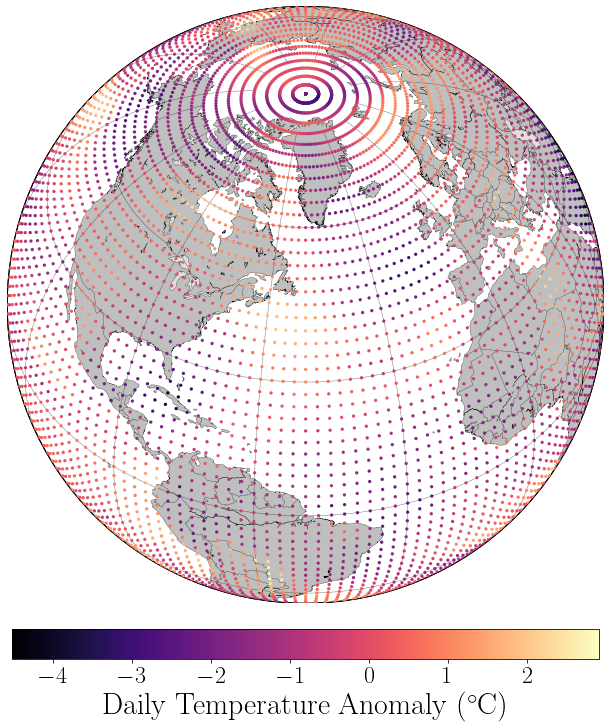

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,12))

lw = 0.5
alpha = 0.5

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=24)
plt.rc('ytick',labelsize=24)

map = Basemap(projection='ortho',lat_0=45,lon_0=-50,resolution='l', ax=ax)
# draw coastlines, country boundaries, fill continents.
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='gray',lake_color=None,alpha=alpha)
# draw the edge of the map projection region (the projection limb)
map.drawmapboundary(fill_color=None,zorder=0)
# draw lat/lon grid lines every 30 degrees.
map.drawmeridians(np.arange(0,360,30),linewidth=lw)
map.drawparallels(np.arange(-90,90,30),linewidth=lw)


# im = map.scatter(latlon_raw[::,1], latlon_raw[::,0], s=10, c='k', latlon=True, zorder=5,
#                  marker='o', edgecolors=None, cmap='magma_r', alpha=1,
#                  vmin=min_degree, vmax=max_degree)#, transform=ccrs.PlateCarree())

i = 0
anomalies_min = min(anomalies_raw[:,i])
anomalies_max = max(anomalies_raw[:,i])
max_magnitude = max(abs(anomalies_min),anomalies_max)
# midpoint = -anomalies_min/(anomalies_max-anomalies_min)
midpoint = 0.5

cmap = mpl.cm.magma
shifted_cmap = shiftedColorMap(cmap, midpoint=midpoint)

im = map.scatter(latlon_raw[::,1], latlon_raw[::,0], s=10, c=anomalies_raw[:,i],
                 latlon=True, zorder=5, marker='o', edgecolors=None, cmap=shifted_cmap, linewidths=0.1,
                 alpha=1)#, vmin=-max_magnitude, vmax=max_magnitude)#, transform=ccrs.PlateCarree())


cbar=plt.colorbar(im, ax=ax, orientation='horizontal',fraction=0.045, pad=0.04)
cbar.set_label(r'Daily Temperature Anomaly ($^{\circ}$C)',fontsize=30)

title = 'Raw Grid'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.show()
plt.close(fig)

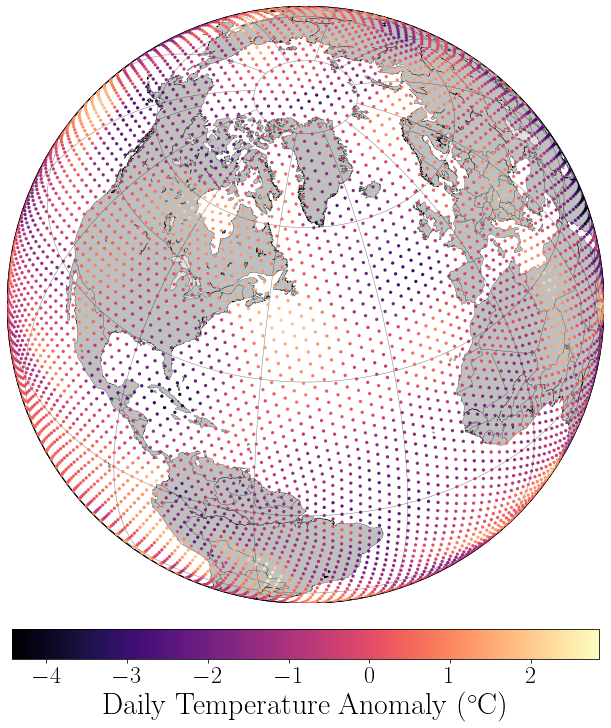

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,12))

lw = 0.5
alpha = 0.5

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=24)
plt.rc('ytick',labelsize=24)

map = Basemap(projection='ortho',lat_0=45,lon_0=-50,resolution='l', ax=ax)
# draw coastlines, country boundaries, fill continents.
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='gray',lake_color=None,alpha=alpha)
# draw the edge of the map projection region (the projection limb)
map.drawmapboundary(fill_color=None,zorder=0)
# draw lat/lon grid lines every 30 degrees.
map.drawmeridians(np.arange(0,360,30),linewidth=lw)
map.drawparallels(np.arange(-90,90,30),linewidth=lw)


# im = map.scatter(latlon_icos[::,1], latlon_icos[::,0], s=10, c='k', latlon=True, zorder=5,
#                  marker='o', edgecolors=None, cmap='magma_r', alpha=1,
#                  vmin=min_degree, vmax=max_degree)#, transform=ccrs.PlateCarree())

i = 0
anomalies_min = min(anomalies_icos[:,i])
anomalies_max = max(anomalies_icos[:,i])
max_magnitude = max(abs(anomalies_min),anomalies_max)
# midpoint = -anomalies_min/(anomalies_max-anomalies_min)
midpoint = 0.5

cmap = mpl.cm.magma
shifted_cmap = shiftedColorMap(cmap, midpoint=midpoint)

im = map.scatter(latlon_icos[::,1], latlon_icos[::,0], s=10, c=anomalies_icos[:,i],
                 latlon=True, zorder=5, marker='o', edgecolors=None, cmap=shifted_cmap, linewidths=0.1,
                 alpha=1)#, vmin=-max_magnitude, vmax=max_magnitude)#, transform=ccrs.PlateCarree())


cbar=plt.colorbar(im, ax=ax, orientation='horizontal',fraction=0.045, pad=0.04)
cbar.set_label(r'Daily Temperature Anomaly ($^{\circ}$C)',fontsize=30)

title = 'Icosahedral Grid'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.show()
plt.close(fig)

In [ ]:
import networkx as nx

with gzip.open(diag_dir + '0.data', 'rb') as file:
    edge_list = pkl.load(file)


G = nx.from_edgelist(edge_list)

H = nx.Graph()
H.add_nodes_from(sorted(G.nodes(data=True)))
H.add_edges_from(G.edges(data=True))
G = H
del H

In [ ]:
print(latlon_icos.shape)

(10242, 2)


In [ ]:
degrees = [val for (node, val) in G.degree()]

ilat1, ilon1, idat1 = interpolate_scatter_data(latlon_icos, degrees, threshold_dateline=0,
                                               threshold_poles=0, replace_nans=True)


extent = [-80+360, -30+360, -20, 10]
filler = 1
ilat2, ilon2, idat2 = interpolate_scatter_data(latlon_icos, degrees, threshold_dateline=0,
                                               threshold_poles=0, replace_nans=True,
                                               extent=extent, filler=filler)

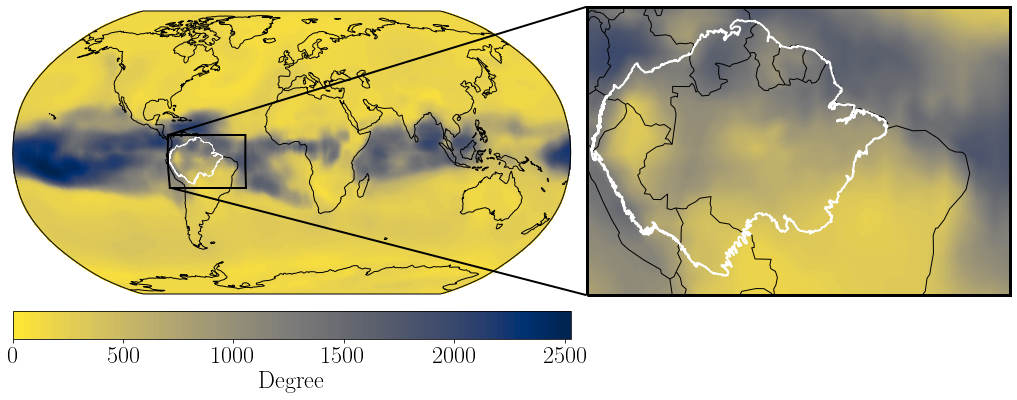

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition, inset_axes, zoomed_inset_axes, mark_inset
from shapely.geometry.polygon import LinearRing
import xarray as xr
from affine import Affine
from glob import glob

aspect_ratio = (extent[1]-extent[0])/(extent[3]-extent[2])
lonmin, lonmax, latmin, latmax = extent

fig = plt.figure(figsize=(10, 8))
proj = ccrs.Robinson(central_longitude=0)
proj_cart = ccrs.PlateCarree()
ax1 = fig.add_subplot(1, 1, 1, projection=proj)
ax1.coastlines()

left, bottom, width, height = [.8, .35, .5*aspect_ratio, .5]
ax2 = fig.add_axes([left, bottom, width, height],
                   projection=ccrs.Robinson(central_longitude=(lonmin + lonmax) / 2))
ax2.set_extent(extent, crs=ccrs.PlateCarree())

# inset location relative to main plot (ax) in normalized units
inset_x = 1
inset_y = 1
inset_size = 0.2

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=24)
plt.rc('ytick',labelsize=24)


ax2.coastlines()
ax2.add_feature(cartopy.feature.BORDERS)



nvert = 100
lons = np.r_[np.linspace(lonmin, lonmin, nvert),
             np.linspace(lonmin, lonmax, nvert),
             np.linspace(lonmax, lonmax, nvert)].tolist()
lats = np.r_[np.linspace(latmin, latmax, nvert),
             np.linspace(latmax, latmax, nvert),
             np.linspace(latmax, latmin, nvert)].tolist()



max_degree = max(degrees)

num_levels = 100
# levels = np.arange(0,max_degree,5)
levels = np.linspace(0,max_degree,100)

im1 = ax1.contourf(ilon1, ilat1, idat1, levels=levels,
                  cmap='cividis_r', alpha=1,
                  vmin=0, vmax=max_degree,
                  linewidths=0,
                  transform=ccrs.PlateCarree())
for c in im1.collections:
    c.set_edgecolor("face")

# matches = glob(diag_dir+'CD06_CAMREX_1086/*_v')
# matches = [match.split('\\')[-1] for match in matches]
# for match in matches:
#     reader = shpreader.Reader(diag_dir+'CD06_CAMREX_1086/'+match+'/'+match+'.shp')
#     amazon = cartopy.feature.ShapelyFeature(list(reader.geometries()), ccrs.PlateCarree())
#     ax2.add_feature(amazon, facecolor='gray', edgecolor='gray', alpha=0.25)

reader = shpreader.Reader(diag_dir+'Amazon Biome/amazonia.shp')
amazon = cartopy.feature.ShapelyFeature(list(reader.geometries()), ccrs.PlateCarree())
ax1.add_feature(amazon, facecolor='none', edgecolor='white', alpha=1, linewidth=1)
ax2.add_feature(amazon, facecolor='none', edgecolor='white', alpha=1, linewidth=2)
# ax2.add_feature(amazon, facecolor='gray', edgecolor='black', alpha=.25)

im2 = ax2.contourf(ilon2, ilat2, idat2, levels=levels,
                  cmap='cividis_r', alpha=1,
                  vmin=0, vmax=max_degree,
                  linewidths=0,
                  transform=ccrs.PlateCarree())
for c in im2.collections:
    c.set_edgecolor("face")

cbar=plt.colorbar(im1, ax=ax1, orientation='horizontal',fraction=0.26, pad=0.04)
cbar.set_label('Degree',fontsize=24)
cbar.set_ticks(np.arange(0,max_degree,500))  # vertically oriented colorbar


coord_data_topleft_ax1 = proj.transform_point(lonmin,latmax,proj_cart)
coord_disp_topleft_ax1 = ax1.transData.transform(coord_data_topleft_ax1)
coord_axes_topleft_ax1 = ax1.transAxes.inverted().transform(coord_disp_topleft_ax1)

coord_data_botleft_ax1 = proj.transform_point(lonmin,latmin,proj_cart)
coord_disp_botleft_ax1 = ax1.transData.transform(coord_data_botleft_ax1)
coord_axes_botleft_ax1 = ax1.transAxes.inverted().transform(coord_disp_botleft_ax1)

coord_data_topright_ax1 = proj.transform_point(lonmax,latmax,proj_cart)
coord_disp_topright_ax1 = ax1.transData.transform(coord_data_topright_ax1)
coord_axes_topright_ax1 = ax1.transAxes.inverted().transform(coord_disp_topright_ax1)

coord_data_botright_ax1 = proj.transform_point(lonmax,latmin,proj_cart)
coord_disp_botright_ax1 = ax1.transData.transform(coord_data_botright_ax1)
coord_axes_botright_ax1 = ax1.transAxes.inverted().transform(coord_disp_botright_ax1)



ax2_pos = ax2.get_position(original=True)
coord_fig_topleft_ax2 = (ax2_pos.x0, ax2_pos.y1)
coord_disp_topleft_ax2 = fig.transFigure.transform(coord_fig_topleft_ax2)
coord_axes_topleft_ax2 = ax1.transAxes.inverted().transform(coord_disp_topleft_ax2)

coord_fig_botleft_ax2 = (ax2_pos.x0, ax2_pos.y0)
coord_disp_botleft_ax2 = fig.transFigure.transform(coord_fig_botleft_ax2)
coord_axes_botleft_ax2 = ax1.transAxes.inverted().transform(coord_disp_botleft_ax2)



ax2.outline_patch.set_edgecolor('k')
ax2.outline_patch.set_linewidth(3)
ring = LinearRing(list(zip(lons, lats)))
ax1.add_geometries([ring], ccrs.PlateCarree(),
                   facecolor='none', edgecolor='k', linewidth=0.75, zorder=5)
ax1.plot([coord_axes_topleft_ax1[0],coord_axes_topleft_ax2[0]+.155],
         [coord_axes_topleft_ax1[1],coord_axes_topleft_ax2[1]+.07],
         'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)
ax1.plot([coord_axes_botleft_ax1[0],coord_axes_botleft_ax2[0]+.155],
         [coord_axes_botleft_ax1[1],coord_axes_botleft_ax2[1]],
         'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)

ax1.plot([lonmin,lonmax], [latmax,latmax], 'k', transform=ccrs.PlateCarree(),
         zorder=5, lw=2)
ax1.plot([lonmax,lonmax], [latmax,latmin], 'k', transform=ccrs.PlateCarree(),
         zorder=5, lw=2)
ax1.plot([lonmax,lonmin], [latmin,latmin], 'k', transform=ccrs.PlateCarree(),
         zorder=5, lw=2)
ax1.plot([lonmin,lonmin], [latmin,latmax], 'k', transform=ccrs.PlateCarree(),
         zorder=5, lw=2)

# ax1.plot([coord_axes_topleft_ax1[0],coord_data_topright_ax1[0]],
#          [coord_axes_topleft_ax1[1],coord_data_topright_ax1[1]],
#          'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)
# ax1.plot([coord_data_topright_ax1[0],coord_data_botright_ax1[0]],
#          [coord_data_topright_ax1[1],coord_data_botright_ax1[1]],
#          'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)
# ax1.plot([coord_data_botright_ax1[0],coord_data_botleft_ax1[0]],
#          [coord_data_botright_ax1[1],coord_data_botleft_ax1[1]],
#          'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)
# ax1.plot([coord_data_botleft_ax1[0],coord_data_topleft_ax1[0]],
#          [coord_data_botleft_ax1[1],coord_data_topleft_ax1[1]],
#          'k',ms=10, transform=ax1.transAxes, zorder=5, clip_on=False, lw=2)


# plt.tight_layout()




title = 'Network on Map Robinson with Amazonia 2'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.show()
plt.close(fig)

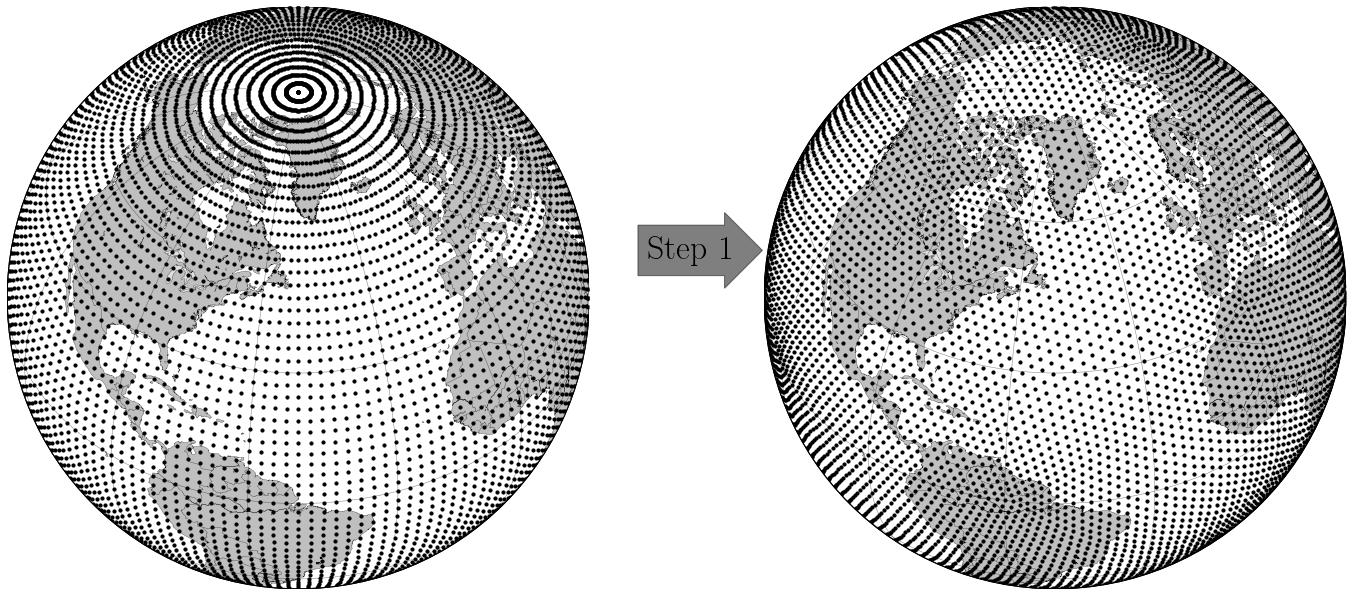

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(24,12))
ax1, ax2 = axs

lw = 0.5
alpha = 0.5
alpha_labels = 0.5

map = Basemap(projection='ortho',lat_0=45,lon_0=-50,resolution='l',ax=ax1)
# draw coastlines, country boundaries, fill continents.
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='gray',lake_color=None,alpha=alpha)
# draw the edge of the map projection region (the projection limb)
map.drawmapboundary(fill_color=None, zorder=0)
# draw lat/lon grid lines every 30 degrees.
map.drawmeridians(np.arange(0,360,30),linewidth=lw)
map.drawparallels(np.arange(-90,90,30),linewidth=lw)

map.scatter(latlon_raw[:,1], latlon_raw[:,0], s=10, c='k', latlon=True, zorder=2)



map = Basemap(projection='ortho',lat_0=45,lon_0=-50,resolution='l',ax=ax2)
# draw coastlines, country boundaries, fill continents.
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='gray',lake_color=None,alpha=alpha)
# draw the edge of the map projection region (the projection limb)
map.drawmapboundary(fill_color=None,zorder=0)
# draw lat/lon grid lines every 30 degrees.
map.drawmeridians(np.arange(0,360,30),linewidth=lw)
map.drawparallels(np.arange(-90,90,30),linewidth=lw)

map.scatter(latlon_icos[:,1], latlon_icos[:,0], s=10, c='k', latlon=True, zorder=2)



# plt.tight_layout()
fig.subplots_adjust(hspace=0,wspace=0.3)

ax1_bbox = ax1.get_tightbbox(fig.canvas.get_renderer())
ax2_bbox = ax2.get_tightbbox(fig.canvas.get_renderer())

# plt.annotate(r'*', usetex=True, color='r', xy=[ax1_bbox.x0,ax1_bbox.y0],
#                xycoords='figure pixels', fontsize=34,
#                ha='center', va='center', rotation=0, zorder=10)
# plt.annotate(r'*', usetex=True, color='r', xy=[ax1_bbox.x0,ax1_bbox.y1],
#                xycoords='figure pixels', fontsize=34,
#                ha='center', va='center', rotation=0, zorder=10)
# plt.annotate(r'*', usetex=True, color='r', xy=[ax1_bbox.x1,ax1_bbox.y0],
#                xycoords='figure pixels', fontsize=34,
#                ha='center', va='center', rotation=0, zorder=10)
# plt.annotate(r'*', usetex=True, color='r', xy=[ax1_bbox.x1,ax1_bbox.y1],
#                xycoords='figure pixels', fontsize=34,
#                ha='center', va='center', rotation=0, zorder=10)

# plt.annotate(r'*', usetex=True, color='r', xy=[ax1_bbox.x1,(ax1_bbox.y0+ax1_bbox.y1)/2],
#                xycoords='figure pixels', fontsize=34,
#                ha='center', va='center', rotation=0)


plt.annotate(r'Step 1', usetex=True, xy=(0.4,0.4),
               xycoords='figure fraction', fontsize=34,
               ha='center', va='center', rotation=0,
               bbox=dict(facecolor='k',boxstyle='rarrow',alpha=alpha_labels))
#                arrowprops=dict(arrowstyle='-|>',color='k',shrinkB=10,))
#                                patchB=mpatches.Circle(pos[node],radius=node_size/2)))

# plt.text(0.5, 0.5, r'Step 1', usetex=True, ha='center', va='center', rotation=45, size=15,
#     bbox=dict(boxstyle="rarrow,pad=0.3", fc="cyan", ec="b", lw=2))



title = 'Raw and Icosahedral Grids'
# plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
# plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.show()
plt.close(fig)

In [ ]:
fig = plt.figure(figsize=(12,12))

class LowerThresholdOrthographic(ccrs.Orthographic):

    @property
    def threshold(self):
        return 1e3



# proj = ccrs.Orthographic(central_longitude=-50, central_latitude=45)
proj = LowerThresholdOrthographic(central_longitude=-50, central_latitude=45)
ax = fig.add_subplot(1, 1, 1, projection=proj)

lw = 0.5
alpha = 0.5

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=24)
plt.rc('ytick',labelsize=24)

ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.LAND, facecolor='gray', alpha=alpha)
ax.add_feature(cartopy.feature.OCEAN, facecolor='w')
ax.coastlines()

# map = Basemap(projection='ortho',lat_0=45,lon_0=-50,resolution='l')

# x_coords = np.zeros((2,len(edge_list)))
# y_coords = np.zeros((2,len(edge_list)))
# k = 0
# for (i,j) in tqdm(edge_list):
#     x1, y1 = latlon_icos[i][1], latlon_icos[i][0]
#     x2, y2 = latlon_icos[j][1], latlon_icos[j][0]
#     x_coords[0,k] = x1
#     x_coords[1,k] = x2
#     y_coords[0,k] = y1
#     y_coords[1,k] = y2
#     k += 1

ax.scatter(latlon_icos[:,1], latlon_icos[:,0], s=10, c='k', transform=ccrs.PlateCarree())
ax.plot(x_coords,y_coords,'r',alpha=0.001,lw=.5,transform=ccrs.PlateCarree())


# nylat = 40.78; nylon = -73.98
# # lonlat, lonlon are lat/lon of London.
# lonlat = 51.53; lonlon = 0.08

# ax.plot([[nylon],[lonlon]], [[nylat],[lonlat]], 'r', lw=2, transform=ccrs.PlateCarree())





# # draw coastlines, country boundaries, fill continents.
# map.drawcoastlines(linewidth=0.25)
# map.drawcountries(linewidth=0.25)
# map.fillcontinents(color='gray',lake_color=None,alpha=alpha)
# # draw the edge of the map projection region (the projection limb)
# map.drawmapboundary(fill_color=None,zorder=0)
# # draw lat/lon grid lines every 30 degrees.
# map.drawmeridians(np.arange(0,360,30),linewidth=lw)
# map.drawparallels(np.arange(-90,90,30),linewidth=lw)


# for (i,j) in tqdm(edge_list):
#     map.drawgreatcircle(latlon_icos[i][1],latlon_icos[i][0],
#                         latlon_icos[j][1],latlon_icos[j][0],
#                         linewidth=0.5,color='r',alpha=0.001)

title = 'Map on Network (Great Circles)'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.show()
plt.close(fig)

In [ ]:
print(ax1.transData.transform_point((lonmin,latmax)))
print(ax1.transAxes.inverted().transform(ax1.transData.transform_point((lonmin,latmax))))
print(proj.transform_point(lonmin,latmax,ccrs.PlateCarree()))
print(proj(lonmin,latmax))
print(ax1.transAxes.inverted().transform(ax1.transData.transform_point((lonmin,latmax))))

[368.99868751 289.44008203]
[0.49999765 0.50000029]
(-7547566.785625717, 534759.5804965122)


TypeError: 'Robinson' object is not callable

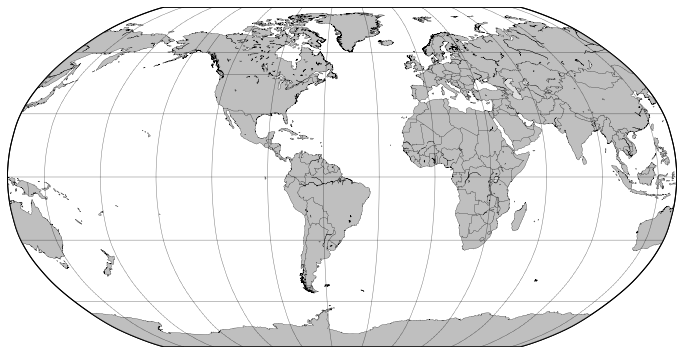

In [ ]:
fig = plt.figure(figsize=(12,24))

lw = 0.5
alpha = 0.5

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=24)
plt.rc('ytick',labelsize=24)

map = Basemap(projection='robin',lat_0=0,lon_0=-50,resolution='l')

# build position dictionary of graph using map
pos = {}
for i in range(len(latlon_icos)):
    x, y = map(latlon_icos[i][1], latlon_icos[i][0])
    pos[i] = (x, y)




# draw coastlines, country boundaries, fill continents.
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='gray',lake_color=None,alpha=alpha)
# draw the edge of the map projection region (the projection limb)
map.drawmapboundary(fill_color=None,zorder=0)
# draw lat/lon grid lines every 30 degrees.
map.drawmeridians(np.arange(0,360,30),linewidth=lw)
map.drawparallels(np.arange(-90,90,30),linewidth=lw)


# nx.draw_networkx_nodes(G, pos=pos, node_color = 'k',
#                        alpha=1, node_size = 10)
nx.draw_networkx_edges(G, pos=pos, edge_color='r', width=.5,
                       alpha=0.001)

title = 'Network on Map Robinson'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.show()
plt.close(fig)

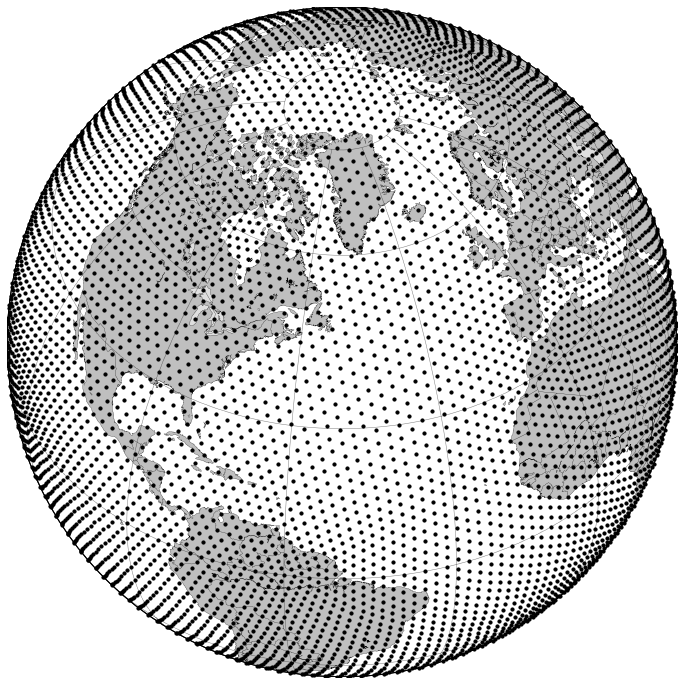

In [ ]:
fig = plt.figure(figsize=(12,24))

lw = 0.5
alpha = 0.5

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=24)
plt.rc('ytick',labelsize=24)

map = Basemap(projection='ortho',lat_0=45,lon_0=-50,resolution='l')

# build position dictionary of graph using map
pos = {}
for i in range(len(latlon_icos)):
    x, y = map(latlon_icos[i][1], latlon_icos[i][0])
    pos[i] = (x, y)




# draw coastlines, country boundaries, fill continents.
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='gray',lake_color=None,alpha=alpha)
# draw the edge of the map projection region (the projection limb)
map.drawmapboundary(fill_color=None,zorder=0)
# draw lat/lon grid lines every 30 degrees.
map.drawmeridians(np.arange(0,360,30),linewidth=lw)
map.drawparallels(np.arange(-90,90,30),linewidth=lw)


nx.draw_networkx_nodes(G, pos=pos, node_color = 'k',
                       alpha=1, node_size = 10)
nx.draw_networkx_edges(G, pos=pos, edge_color='r', width=.5,
                       alpha=0.001)

title = 'Network on Map (2)'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.show()
plt.close(fig)

In [ ]:
print(pos)

{0: (13557686.11566354, 8615499.2431), 1: (13917689.808383271, 8615499.2431), 2: (14289487.008031389, 8615499.2431), 3: (14670027.9145738, 8615499.2431), 4: (15055733.818010222, 8615499.2431), 5: (15442760.591336433, 8615499.2431), 6: (15827167.483323703, 8615499.2431), 7: (16205165.138011942, 8615499.2431), 8: (16573348.058490865, 8615499.2431), 9: (16928836.919218358, 8615499.2431), 10: (17269377.582455695, 8615499.2431), 11: (17593382.191455796, 8615499.2431), 12: (17899863.04762697, 8615499.2431), 13: (18188404.57289159, 8615499.2431), 14: (18459033.74347229, 8615499.2431), 15: (18712138.029159307, 8615499.2431), 16: (18865885.153871156, 8615499.2431), 17: (19024869.172115996, 8615499.2431), 18: (19189073.81568552, 8615499.2431), 19: (19358442.644433245, 8615499.2431), 20: (19532875.37518387, 8615499.2431), 21: (19712221.125404023, 8615499.2431), 22: (19896283.657671165, 8615499.2431), 23: (20084807.598992847, 8615499.2431), 24: (20277479.285779376, 8615499.2431), 25: (20473934.961

In [ ]:
with gzip.open(diag_dir + '0 (1).data', 'rb') as file:
    edge_list1 = pkl.load(file)

In [ ]:
print(edge_list1.shape)

(13107199, 2)


In [ ]:
with gzip.open(diag_dir + '0 (1).data', 'rb') as file:
    edge_list1 = pkl.load(file)

import networkx as nx

G1 = nx.from_edgelist(edge_list1)

H = nx.Graph()
H.add_nodes_from(sorted(G1.nodes(data=True)))
H.add_edges_from(G1.edges(data=True))
G1 = H
del H

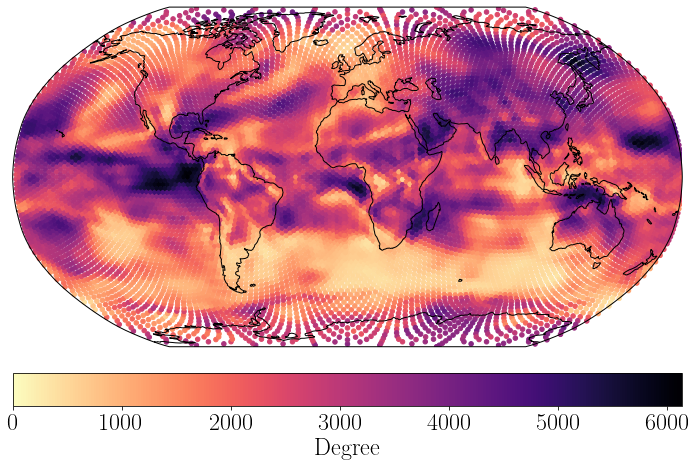

In [ ]:
fig = plt.figure(figsize=(12,12))



proj = ccrs.Robinson(central_longitude=-0)
ax = fig.add_subplot(1, 1, 1, projection=proj)

lw = 0.5
alpha = 0.5

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=24)
plt.rc('ytick',labelsize=24)

ax.coastlines()

im = ax.scatter(latlon_icos[:,1], latlon_icos[:,0], s=20,
                c=[val for (node, val) in G1.degree()], marker='o',
                edgecolors=None, cmap='magma_r', alpha=1,
                vmin=0,
                transform=ccrs.PlateCarree())


cbar=plt.colorbar(im, ax=ax, orientation='horizontal',fraction=0.26, pad=0.04)
cbar.set_label('Degree',fontsize=24)



title = 'Degrees of First Graph'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.show()
plt.close(fig)

In [ ]:
from scipy.interpolate import griddata

degrees1 = [val for (node, val) in G1.degree()]

ilon3 = np.linspace(0, 360, 200)
ilat3 = np.linspace(-90, 90, 200)
ilon3, ilat3 = np.meshgrid(ilon3, ilat3)
idat3 = griddata((latlon_icos[:,1], latlon_icos[:,0]), degrees1,
                (ilon3, ilat3), method="linear")
# idat3_nearest = griddata((latlon_icos[:,1], latlon_icos[:,0]), degrees1,
#                 (ilon3, ilat3), method="nearest")
where = np.where(np.isnan(idat3))
# idat3[where] = idat3_nearest[where]

In [ ]:
ilat, ilon, idat = interpolate_scatter_data(latlon_icos, [val for (node, val) in G1.degree()],
                                            threshold_dateline=0, threshold_poles=0, replace_nans=True)

In [ ]:
where = np.where(np.isnan(idat))
lats = ilat[where[0],0]
lons = ilon[0,where[1]]
print(lats.shape, lons.shape)
print(len(lats), len(lons))

for i in range(len(where[0])):
    print(lats[i], lons[i])

(0,) (0,)
0 0


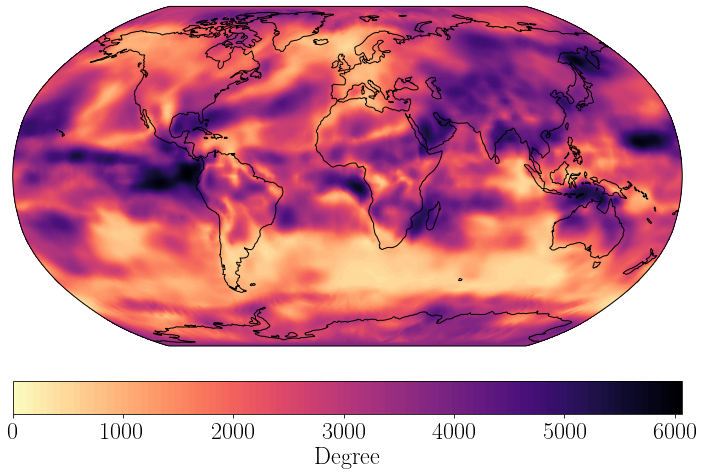

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition, inset_axes, zoomed_inset_axes, mark_inset
from shapely.geometry.polygon import LinearRing

fig = plt.figure(figsize=(12, 16))
proj = ccrs.Robinson(central_longitude=0)
proj_cart = ccrs.PlateCarree()
ax1 = fig.add_subplot(1, 1, 1, projection=proj)
ax1.coastlines()

plt.rc('text', usetex=True)
plt.rc('xtick',labelsize=24)
plt.rc('ytick',labelsize=24)

max_degree1 = np.nanmax(idat)


# im1 = ax1.scatter(latlon_icos[:,1], latlon_icos[:,0], s=20,
#                 c=degrees, marker='o',
#                 edgecolors=None, cmap='magma_r', alpha=1,
#                 vmin=0, vmax=max_degree,
#                 transform=ccrs.PlateCarree())


# lons = np.ravel(ilon3,)
# lats = np.ravel(ilat3,'C')
# dat = np.ravel(idat3)

# im1 = ax1.scatter(lons, lats, c=results,
#                   cmap='magma_r', alpha=1, s=20, marker='o',
#                   vmin=0, vmax=max_degree1,
#                   transform=ccrs.PlateCarree())

levels1 = np.linspace(0,max_degree1,100)
# levels1 = np.arange(0,max_degree1,50)

im1 = ax1.contourf(ilon, ilat, idat, levels=levels1,
                  cmap='magma_r', alpha=1,
                  vmin=0, vmax=max_degree1,
                  transform=ccrs.PlateCarree())
# im1 = ax1.contourf(ilon3, ilat3, results.reshape((200,200)), levels=levels1,
#                   cmap='magma_r', alpha=1,
#                   vmin=0, vmax=max_degree1,
#                   transform=ccrs.PlateCarree())


cbar=plt.colorbar(im1, ax=ax1, orientation='horizontal',fraction=0.26, pad=0.04)
cbar.set_label('Degree',fontsize=24)
cbar.set_ticks(np.arange(0,max_degree1,1000))  # vertically oriented colorbar



# plt.tight_layout()




title = 'Degrees of First Graph (Countour) 2'
plt.savefig(fig_dir+title+'.jpg',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.savefig(fig_dir+title+'.pdf',bbox_inches='tight',pad_inches=0.2, dpi=300)
plt.show()
plt.close(fig)

In [ ]:
print(np.min(idat), np.max(idat))

326.28357213221386 6067.8374014530345


In [ ]:


degrees1 = [val for (node, val) in G1.degree()]

ilon3 = np.linspace(0, 360, 200)
ilat3 = np.linspace(-90, 90, 200)
ilon3, ilat3 = np.meshgrid(ilon3, ilat3)
idat3 = griddata((latlon_icos[:,1], latlon_icos[:,0]), degrees1,
                (ilon3, ilat3), method="linear")
# idat3_nearest = griddata((latlon_icos[:,1], latlon_icos[:,0]), degrees1,
#                 (ilon3, ilat3), method="nearest")
where = np.where(np.isnan(idat3))
# idat3[where] = idat3_nearest[where]

In [ ]:
threshold = 30
radius = 2000

print(ilon3[0,close_to_lon_0])

lons = [ilon3[0,lon] for lon in close_to_lon_0 for i in range(len(ilat3[:,0]))]
lats = [lat for i in range(len(close_to_lon_0)) for lat in ilat3[:,0]]


results_close_to_lon_0 = interpolate_points(lats,lons,latlon_icos,degrees1)#, radius=radius)

nj = len(ilat3[:,0])
for i in range(len(close_to_lon_0)):
    lon_ind = close_to_lon_0[i]
    for j in range(nj):
        idat3[j,lon_ind] = results_close_to_lon_0[nj*i + j]
#         print(idat3[lon_ind,j])
#         print(nj*i+j,ilon3[0,lon_ind], ilat3[j,0], idat3[lon_ind,j], results_close_to_lon_0[nj*i+j])

[  0.           1.80904523   3.61809045   5.42713568   7.2361809
   9.04522613  10.85427136  12.66331658  14.47236181  16.28140704
  18.09045226  19.89949749  21.70854271  23.51758794  25.32663317
  27.13567839  28.94472362 331.05527638 332.86432161 334.67336683
 336.48241206 338.29145729 340.10050251 341.90954774 343.71859296
 345.52763819 347.33668342 349.14572864 350.95477387 352.7638191
 354.57286432 356.38190955 358.19095477 360.        ]
